# Clustering FakeNewsNet

___OBS:___ _The data examined in this notebook can be downloaded from [here](https://www.kaggle.com/datasets/mdepak/fakenewsnet?resource=download&select=PolitiFactUserFeature.mat)_

### Table of Contents
1. [Initial processing of the data set](#processing)
2. [Constructing a generic BuzzFeed featurizer](#featurizer)
3. [Analyzing the FakeNewsNet-BuzzFeed graph](#graph-analysis)

In [4]:
from tqdm import tqdm
tqdm.pandas()

import os
import warnings
from typing import List
from pathlib import Path
from itertools import product
from collections import defaultdict, Counter

import math
import numpy as np
import pandas as pd

import networkx as nx
from node2vec import Node2Vec

import netwulf as nw
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score, f1_score, precision_score, recall_score, balanced_accuracy_score

pd.options.future.infer_string = True

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext watermark
%watermark --iversions

c:\Users\alber\Miniconda3\envs\02807\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pandas    : 2.1.0
nltk      : 3.8.1
netwulf   : 0.1.5
re        : 2.2.1
numpy     : 1.25.2
networkx  : 2.8.8
matplotlib: 3.8.0



<a class="anchor" id="processing"></a>
## 1. Initial processing of the data set

Initially, the dataset will be loaded and processed before 1) $K$ train/test splits are created with the incentive to run cross-validation for getting the generalization error and 2) training and evaluating model performances. Through initial investigations we found that the provided PolitiFact data was corrupted in the sense that the text-content of fake- and real news were identical. For this reason, we restrict the analysis to the BuzzFeed dataset.

In [5]:
# Set dataset name and path to data folder
dataset     = 'BuzzFeed'
DATA_DIR    = Path("../data")

At first, we load the news- and user indices and construct a mapping between users and the news that they shared.

In [3]:
# Load social content data - i.e. user and news "interactions" 
newsId              = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}News.txt', sep='\t', header=None)
userId              = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}User.txt', sep='\t', header=None)

# Create index mappings
idx2newsId          = {i+1: key for i, key in enumerate(newsId[0])}
idx2userId          = {i+1: key for i, key in enumerate(userId[0])}

# Add real user and news ids/names to dataframe
NewsUser            = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}NewsUser.txt', sep='\t', header=None).rename(columns={0: 'newsIndex', 1: 'userIndex', 2: 'n_shares'})
NewsUser['newsId']  = NewsUser['newsIndex'].map(idx2newsId) 
NewsUser['userId']  = NewsUser['userIndex'].map(idx2userId)

# Show resulting dataframe
print(NewsUser.shape)
NewsUser.head()

(22779, 5)


,newsIndex,userIndex,n_shares,newsId,userId
0,45,1,1,BuzzFeed_Real_45,98d2b98ce305174e2f6c10b8f8a1a9d5
1,127,2,1,BuzzFeed_Fake_36,a273d0fd07c18a884ce2aa425813eb06
2,115,3,1,BuzzFeed_Fake_24,ac091e92df9e854a07563ffb397925d4
3,180,3,1,BuzzFeed_Fake_89,ac091e92df9e854a07563ffb397925d4
4,140,4,1,BuzzFeed_Fake_49,d2ded2de054f2ceb43dff7f80fc46774


Next we collect the fake- and real news in a single dataframe along with the respective news IDs.

In [4]:
# Load content of news data
fake_news       = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}_fake_news_content.csv', engine="pyarrow")
real_news       = pd.read_csv(DATA_DIR / f'raw/FakeNewsNet/{dataset}_real_news_content.csv', engine="pyarrow")
df              = pd.concat([real_news, fake_news]).reset_index(drop=True)

# Add news id to dataframe
df['news_id']   = newsId

# Save processed data
df.to_csv(DATA_DIR / f'processed/FakeNewsNet/{dataset}NewsContent.csv', index=False)

#### FakeNews Kaggle dataset
We apply similar steps to the FakeNews dataset from Kaggle, however, it does not contain relational information, only text.



In [5]:
# Load data file
df_kaggle = pd.read_csv(DATA_DIR / f'raw/fake-news/train.csv')

# Set initial news ids
news_ids = []
real_index = 1
fake_index = 1

# Add news ids to dataframe to correspond with FakeNewsNet
for i, article in tqdm(df_kaggle.iterrows(), total=df_kaggle.shape[0], desc='Adding news ids'):
    if article['label'] == 1:
        id_ = 'Fake_' + str(fake_index)
        fake_index += 1
    else:
        id_ = 'Real_' + str(real_index)
        real_index += 1
    news_ids.append(id_)

df_kaggle['news_id'] = news_ids
df_kaggle = df_kaggle.dropna().reset_index(drop=True)

# Save 
df_kaggle.to_csv(DATA_DIR / f'processed/FakeNewsNet/FakeNewsKaggle.csv', index=False)

Adding news ids: 100%|██████████| 20800/20800 [00:01<00:00, 15979.16it/s]


### Word clouds of real and fake articles

In [6]:
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 100%%, %d%%)" % np.random.randint(30, 70)  # Return the color of the text

def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(120, 40%%, %d%%)" % np.random.randint(30, 70)  # Return the color of the text

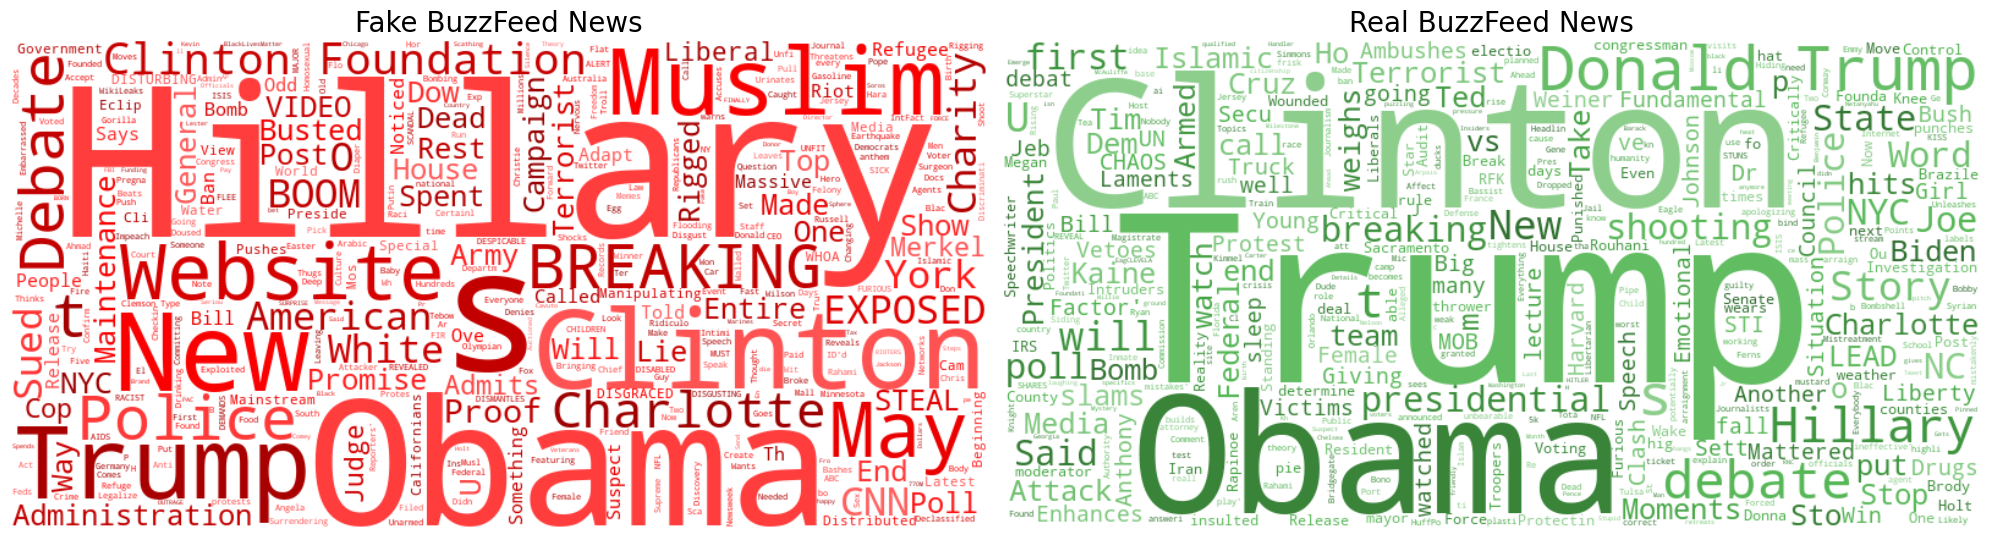

In [7]:
fake_news["full_text"] = fake_news["title"] + " " + fake_news["text"]
real_news["full_text"] = real_news["title"] + " " + real_news["text"]

# Create a word cloud for the fake news
wordcloud_fake = WordCloud(background_color="white",
                           max_words=5000,
                           contour_width=3,
                           contour_color='steelblue',
                           color_func=red_color_func,
                           width=800,  
                           height=400  
                          )
wordcloud_fake.generate(fake_news["full_text"].to_string())
wordcloud_fake.to_image()

# Create a word cloud for the real news
wordcloud_real = WordCloud(background_color="white",
                           max_words=5000,
                           contour_width=3,
                           contour_color='steelblue',
                           color_func=green_color_func,
                           width=800,  
                           height=400  
                          )
wordcloud_real.generate(real_news["full_text"].to_string())
wordcloud_real.to_image()

# Set up the figure and axes
fig, axarr = plt.subplots(1, 2, figsize=(20, 10))  # 1x2 grid of plots, adjust the figure size as needed

# Display the fake news word cloud on the left subplot
axarr[0].imshow(wordcloud_fake, interpolation='bilinear')
axarr[0].axis('off')
axarr[0].set_title("Fake BuzzFeed News", fontsize=20)

# Display the real news word cloud on the right subplot
axarr[1].imshow(wordcloud_real, interpolation='bilinear')  # Make sure you're showing wordcloud_real here
axarr[1].axis('off')
axarr[1].set_title("Real BuzzFeed News", fontsize=20)

# Adjust the spacing between the plots if necessary
plt.tight_layout()

plt.savefig("../reports/figures/BuzzFeedwordcloud.png", bbox_inches='tight')

plt.show()
del df, fake_news, real_news

### Constructing the FakeNewsNet-graph

We aim at representing the relation between news articles. As such, the final goal is to try to cluster news articles and evaluate these clusters compared to the ground truth _news/fake news_ labeling. For doing so, we construct a undirected graph with news articles as nodes and edges being defined by news article having at least two Twitter users that shares the article in common. Thus, the graph is constructed in the following steps:
1) Remove all singleton articles, i.e. find and remove all users that only shared one article
2) For all remaining users, find all tuple combinations of articles from the users sharing history (without self-loops)
3) Add weight to the edges by considering the amount of users that shared both the target and source node.
4) Build the undirected graph using `networkx`

In [8]:
# Find and remove all users that only shared one article
activeUsers         = np.sort(NewsUser['userIndex'].unique())[NewsUser.groupby('userIndex').size() > 1]
activeUsers_idxs    = NewsUser['userIndex'].apply(lambda x: x in activeUsers)
NewsUser_rev        = NewsUser[activeUsers_idxs]

In [9]:
def get_tuple_combinations(list1, list2):
    # Inspiration found online
    combinations = [(item1, item2) for item1, item2 in product(list1, list2) if item1 != item2 and item1 < item2]
    return combinations

# Prepare dictionary for storing edge information
connections = {'weights': defaultdict(int), 'userIds': defaultdict(list)}

# Consider news articles shared by each user
for user in tqdm(activeUsers, desc='Retrieving article links...'):
    # Extract information from the specific user
    user_content    = NewsUser_rev.query(f'userIndex == {user}')
    # Get all tuple-combination of shared articles
    connected_posts = get_tuple_combinations(user_content['newsIndex'], user_content['newsIndex'])
    
    # Add weight and userId to edge information
    for link in connected_posts:
        connections['weights'][link] += 1
        connections['userIds'][link].append(user)

Retrieving article links...: 100%|██████████| 3002/3002 [00:04<00:00, 645.12it/s]


Now, we can construct the weighted edgelist and save it.

In [10]:
# Construct weighted edgelist from the stored information
node1, node2                = list(zip(*connections['weights'].keys()))
weighted_edgelist           = pd.DataFrame([node1, node2, connections['weights'].values()], index=['source', 'target', 'weight']).T
weighted_edgelist['source'] = weighted_edgelist['source'].map(idx2newsId)
weighted_edgelist['target'] = weighted_edgelist['target'].map(idx2newsId)

# Store training graph and full graph
weighted_edgelist.to_csv(DATA_DIR / f'processed/FakeNewsNet/{dataset}_full_graph_weighted_edgelist.csv', index=False)
del weighted_edgelist

<a class="anchor" id="featurizer"></a>
## 2. Constructing a generic featurizer

Next, we seek to construct a `Featurizer` object that contains functionalities for loading case-specific features (i.e. text- or graph variations) for each fold. This class along with auxiliary transformation functions are presented below.

In [29]:
# Download the stopwords dataset
nltk.download('stopwords', quiet=True)

def tokenize(text, stemmer, stop_words):
    """Tokenize text, stem, and remove stop words."""
    tokens = re.findall(r'\b\w+\b', text.lower())
    return [stemmer.stem(token) for token in tokens if token not in stop_words]

def compute_tfidf_train(df, column_name):
    stemmer     = PorterStemmer()
    stop_words  = set(stopwords.words('english'))

    # Tokenize, stem and compute term frequency for each document
    tf, token_text = [], []
    for i, x in enumerate(tqdm(df[column_name], desc='Tokenizing and stemming...')):
        tokens  = tokenize(x, stemmer, stop_words)
        tf.append(Counter(tokens))
        token_text.append(" ".join(tokens))

    # Store in dataframe
    df['tf']                = tf
    df['tokenized_text']    = token_text

    # Create a list of all unique words in the corpus
    all_unique_words = list(set(word for tf in df['tf'] for word in tf.keys()))

    # Compute the number of documents in which each word appears
    word_document_count = Counter(word for tf in df['tf'] for word in tf.keys())

    # Compute the total number of documents
    total_documents = len(df)

    # Compute inverse document frequency for each word
    idf = {word: math.log(total_documents / count) for word, count in word_document_count.items()}

    # Initialize TF-IDF matrix
    N, M        = df.__len__(), all_unique_words.__len__()
    tf_idf      = np.zeros((N, M), dtype=np.float32)
    # Create mapping from word to index in the document
    term2idx    = {w: i for i, w in enumerate(all_unique_words)}

    # Assign TF-IDF values to matrix
    for doc_loc, doc in enumerate(tqdm(df['tf'], desc='Computing TF-IDF...')):
        doc_terms, term_count       = list(doc.keys()), list(doc.values())
        term_freqs                  = np.array(term_count) / sum(term_count)
        
        # Find location of each term in the document and assign TF-IDF value at those locations
        term_locs                   = list(map(lambda x: term2idx[x], doc_terms))
        tf_idf[doc_loc, term_locs]  = term_freqs * np.array([idf[term] for term in doc_terms])
    
    return tf_idf, all_unique_words, idf, df

# We create a separate function for the test data because we need to use the IDF from the training data
def compute_tfidf_test(df, column_name, train_unique_words, train_idf):
    stemmer     = PorterStemmer()
    stop_words  = set(stopwords.words('english'))

    print("Tokenizing and stemming (test data)...")
    df['tf']    = df[column_name].progress_apply(lambda x: Counter(tokenize(x, stemmer, stop_words)))

    # Initialize TF-IDF matrix
    N, M        = df.__len__(), train_unique_words.__len__()
    tf_idf      = np.zeros((N, M), dtype=np.float32)
    # Create mapping from word to index in the document
    term2idx    = {w: i for i, w in enumerate(train_unique_words)}

    # Assign TF-IDF values to matrix
    for doc_loc, doc in tqdm(enumerate(df['tf']), desc='Computing TF-IDF...'):
        doc_terms, term_freqs       = np.array(list(doc.keys())), np.array(list(doc.values()))
        # Filter out non-existing terms
        filt_                       = [term_ in train_idf.keys() for term_ in doc_terms]
        doc_terms, term_freqs       = doc_terms[filt_], term_freqs[filt_]

        term_locs                   = np.array(list(map(lambda x: term2idx[x], doc_terms)))
        tf_idf[doc_loc, term_locs]  = np.array(term_freqs) / sum(term_freqs) * np.array([train_idf[term] for term in doc_terms])
    
    return tf_idf

def tf_idf(Xtrain, Xtest):
    # Compute TF-IDF matrices
    Xtrain, all_unique_words, idf, df = compute_tfidf_train(Xtrain, 'full_text')   
    Xtest = compute_tfidf_test(Xtest, 'full_text', all_unique_words, idf) 

    # Normalize TF-IDF vectors
    Xtrain      = normalize(Xtrain, axis=1)
    if len(Xtest) != 0:
        Xtest   = normalize(Xtest, axis=1) 

    return Xtrain, Xtest, all_unique_words, df

def spectral_clustering(A, train_idxs, test_idxs, K_clusters, mode='text'):
    """ 
    Implementation following this paper, where arguments related to taking the maximum eigenvalues are used: 
    https://proceedings.neurips.cc/paper_files/paper/2001/file/801272ee79cfde7fa5960571fee36b9b-Paper.pdf
    """
    if mode == 'graph':
        nodes                   = A.nodes()
        train_idxs, test_idxs   = [i for i, node in enumerate(nodes) if node in train_idxs], [i for i, node in enumerate(nodes) if node in test_idxs]
        A                       = np.array(nx.adjacency_matrix(A).todense())

    np.fill_diagonal(A, 0)
    
    # Compute degree matrix and degree power matrix
    degree_matrix           = np.diag(A.sum(axis=0).flatten())
    degree_power_matrix     = np.diag(np.power(np.diagonal(degree_matrix), -0.5))

    # L = D^-0.5 * A * D^-0.5
    laplacian                       = degree_power_matrix.dot(A).dot(degree_power_matrix)
    laplacian[np.isnan(laplacian)]  = 0
    assert np.allclose(np.tril(laplacian), np.triu(laplacian).T), 'Laplacian is not symmetric which is required for using np.linalg.eigh!'
    
    # Compute ordered eigenvalues and eigenvectors
    eigenvals, eigenvecs = np.linalg.eigh(laplacian)
    assert np.allclose(eigenvals, np.array(sorted(eigenvals))), 'Eigenvalues are not ordered correctly!'

    # Get largest eigenvals
    k_largest   = np.argpartition(eigenvals, -K_clusters)[-K_clusters:]
        
    # Restrict spectral embeddings to K clusters and normalize wrt. training set features # TODO: check whether this splittingis allowed !
    Xtrain      = eigenvecs[train_idxs, :][:, k_largest]
    Xtest       = eigenvecs[test_idxs, :][:, k_largest]
    Xtrain      = Xtrain[:, :K_clusters] / np.linalg.norm(Xtrain, axis=1)[:, None] 
    Xtest       = Xtest[:, :K_clusters] / np.linalg.norm(Xtest, axis=1)[:, None]

    # Split into train and test features
    if mode == 'text':
        return Xtrain, Xtest 
    else:
        ytrain  = np.array(['Real' in node for node in np.array(nodes)[train_idxs]]).astype(int).ravel()
        ytest   = np.array(['Real' in node for node in np.array(nodes)[test_idxs]]).astype(int).ravel()
        
        if np.isnan(Xtrain).any():
            Xtrain[np.isnan(Xtrain)]    = 0
        if np.isnan(Xtest).any():
            Xtest[np.isnan(Xtest)]      = 0

        return Xtrain, ytrain, Xtest, ytest

def transform_node2vec(G, train_idxs, test_idxs, dimensions: int = 32, walk_length: int = 10, num_walks: int = 100, window: int = 10, min_count: int = 1):   
    ### READ MORE ABOUT NODE2VEC HERE: https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef ###
    
    np.random.seed(0)
    
    # Generate walks
    node2vec    = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, quiet=True)
    model       = node2vec.fit(window=window, min_count=min_count)

    # Get vector representations of splits
    train2vec       = {node_: model.wv.vectors[i] for i, node_ in enumerate(model.wv.index_to_key) if node_ in train_idxs}
    test2vec        = {node_: model.wv.vectors[i] for i, node_ in enumerate(model.wv.index_to_key) if node_ in test_idxs}

    # Modify training split
    Xtrain          = np.array(list(train2vec.values()))
    ytrain          = np.array(['fake' if 'fake' in node_.lower() else 'real' for node_ in model.wv.index_to_key if node_ in train_idxs]) 
    ytrain          = (ytrain == 'real').astype(int)

    # Modify test split
    Xtest           = np.array(list(test2vec.values()))
    ytest           = np.array(['fake' if 'fake' in node_.lower() else 'real' for node_ in model.wv.index_to_key if node_ in test_idxs])
    ytest           = (ytest == 'real').astype(int)
    return Xtrain, ytrain, Xtest, ytest

In [30]:
class Featurizer:

    def __init__(self, dataset: str, datapath: str, K: int = 10, seed=0):
        
        # Define inputs
        self.dataset        = dataset
        self.datapath       = datapath
        self.K              = K
        # Initialize feature matrices
        self.tf_idf_matrix  = None
        self.tf_idf_news_id = None
        self.lsa_matrix     = None
        # Load datasets
        self.text           = self.load_text()
        self.full_graph     = self.load_graph()
        self.labels         = pd.DataFrame(['Real' if 'real' in id_.lower() else 'Fake' for id_ in self.text['news_id']], index=self.text['news_id'])
        # Get dataset train/test splits for all folds
        self.split_indices  = self.get_split_indices(seed=seed)

    def get_split_indices(self, seed):
        np.random.seed(seed)

        # Permute all labels
        permuted_ids        = np.random.permutation(self.text['news_id'].unique())
        n_per_fold          = int(len(permuted_ids) / self.K)

        # Run splitting algorithm
        splits = {}
        for fold_ in range(self.K):
            test_ids        = permuted_ids[n_per_fold * fold_ : n_per_fold * (fold_ + 1)]
            train_ids       = np.setdiff1d(permuted_ids, test_ids)
            splits[fold_]   = {'test': test_ids, 'train': train_ids}
        return splits

    def load_text(self):
        # Load preprocessed text dataframe (BuzzFeed)
        df_buzzfeed              = pd.read_csv(self.datapath / 'BuzzFeedNewsContent.csv')
        df_buzzfeed["full_text"] = df_buzzfeed["title"] + " " + df_buzzfeed["text"]
        
        if self.dataset == 'BuzzFeed':
            df = df_buzzfeed
        elif self.dataset == 'FakeNewsKaggle':
            # Load preprocessed text dataframe (FakeNewsKaggle)
            df                  = pd.read_csv(self.datapath / 'FakeNewsKaggle.csv')
            df["full_text"]     = df["title"] + " " + df["text"]

            # Create TF-IDF matrix if it does not yet exist
            df                  = self.load_tf_idf(df, df_buzzfeed)
        
        return df

    def load_lsa(self, dataset: str = 'large'):
        if os.path.exists(self.datapath / f'{dataset}_lsa-matrix.npz'):
            # Load news ids from tf-idf file
            if self.tf_idf_news_id is None:
               _               = self.load_tf_idf(feature_mode='lsa', dataset=dataset)
            
            # Extract and load LSA matrix
            self.lsa_matrix = np.load(self.datapath / f'{dataset}_lsa-matrix.npz', allow_pickle=True)['lsa_matrix']
            # Load precomputed LSA
            self.lsa_matrix             = pd.DataFrame(self.lsa_matrix)
            self.lsa_matrix['label']    = self.tf_idf_news_id

            # Remove large TF-IDF matrix if using another feature mode
            self.tf_idf_matrix = None
               
        else:
            raise FileExistsError("The LSA matrix does not exist! Please run the script 'src.features.lsa.py' to create it! (OBS: high memory load...)")
    
    def load_tf_idf(self, large_df=None, buzzfeed_df=None, feature_mode='tf-idf', dataset: str = 'large'):
    
        # for computational reasons we compute the TF-IDF before running 5-fold cross validation. This will raise an issue for
        # test articles that contain words not occurring in the training set which would usually disappear in the test TF-IDF, however,
        # this will not happen here as the TF-IDF is fitted on the full dataset.
        if os.path.exists(self.datapath / f'{dataset}_tf-idf.npz'):
            print("Loading pre-computed TF-IDF matrix...")
            tf_idf_info = np.load(self.datapath / f'{dataset}_tf-idf.npz', allow_pickle=True)

            # Extract information     
            self.tf_idf_matrix, self.tf_idf_news_id, self.all_unique_words = tf_idf_info['tf_idf'], tf_idf_info['news_id'], tf_idf_info['all_unique_words']
            print("Loaded TF-IDF matrix of shape {} from disk!".format(self.tf_idf_matrix.shape))
            
        else:
            if buzzfeed_df is None:
                buzzfeed_df = pd.DataFrame(columns=large_df.columns)
            
            # Create TF-IDF matrix
            self.tf_idf_matrix, tf_idf_matrix_buzzfeed, self.all_unique_words, large_df = tf_idf(large_df, buzzfeed_df)
            self.tf_idf_news_id                                                         = large_df['news_id'].to_numpy()
            
            # Save TF-IDF matrix
            np.savez_compressed(self.datapath / 'large_tf-idf.npz', tf_idf=self.tf_idf_matrix, news_id=self.tf_idf_news_id, all_unique_words=self.all_unique_words)
            np.savez_compressed(self.datapath / 'BuzzFeed_tf-idf.npz', tf_idf=tf_idf_matrix_buzzfeed, news_id=buzzfeed_df['news_id'].to_numpy(), all_unique_words=self.all_unique_words)
            print("Saved large TF-IDF matrix of shape {} to disk!".format(self.tf_idf_matrix.shape))
            print("Saved BuzzFeed TF-IDF matrix of shape {} to disk!".format(tf_idf_matrix_buzzfeed.shape))
            
            # Save tokenized text
            large_df[['tokenized_text', 'label']].to_csv(self.datapath / 'large_tokenized-text.csv', index=False)
        
        return large_df

    def load_graph(self):
        if self.dataset == 'BuzzFeed':
            # Load edgelist of full network
            self.weighted_edgelist = pd.read_csv(self.datapath / f'BuzzFeed_full_graph_weighted_edgelist.csv')
            # Create networkx graph
            return nx.from_pandas_edgelist(self.weighted_edgelist, source='source', target='target', edge_attr='weight', create_using=nx.Graph)
        
    def get_feature_split(self, feature_mode: str, fold: int, seed: int = 42, **kwargs):
        np.random.seed(seed)
        feature_info = {}

        # Get train and test ids
        train_idxs, test_idxs       = self.split_indices[fold]['train'], self.split_indices[fold]['test']
        
        ### TEXT REPRESENTATIONS ###
        if feature_mode in ['tf-idf', 'lsa', 'spectral_text']: 
            Xtrain, Xtest           = self.text.query('news_id in @train_idxs').reset_index(drop=True), self.text.query('news_id in @test_idxs').reset_index(drop=True)
            ytrain                  = (self.labels.query('news_id in @train_idxs').reset_index(drop=True) == 'Real').astype(int).values.ravel()
            ytest                   = (self.labels.query('news_id in @test_idxs').reset_index(drop=True) == 'Real').astype(int).values.ravel()

            # Get TF-IDF representations                
            if self.dataset == 'BuzzFeed':
                if feature_mode == 'tf-idf':
                    Xtrain, Xtest   = tf_idf(Xtrain, Xtest)
                else:
                    # Load precomupted LSA features
                    self.load_lsa(dataset='BuzzFeed')
                    Xtrain  = self.lsa_matrix.query('label in @train_idxs').drop(columns='label').to_numpy()
                    Xtest   = self.lsa_matrix.query('label in @test_idxs').drop(columns='label').to_numpy()

            else:
                # Get train and test matrices
                if feature_mode == 'tf-idf':
                    # Load precomputed TF-IDF matrix
                    if self.tf_idf_news_id is None:
                        _           = self.load_tf_idf(feature_mode='tf-idf', dataset='large')
                    Xtrain, Xtest   = self.tf_idf_matrix[train_idxs, :], self.tf_idf_matrix[test_idxs, :]
                    
                elif feature_mode in ['spectral_text', 'lsa']:
                    # Load precomupted LSA features
                    self.load_lsa(dataset='large')
                    # Xtrain, Xtest   = self.lsa_matrix[train_idxs, :], self.lsa_matrix[test_idxs, :]                        
                    Xtrain  = self.lsa_matrix.query('label in @train_idxs').drop(columns='label').to_numpy()
                    Xtest   = self.lsa_matrix.query('label in @test_idxs').drop(columns='label').to_numpy()                       
                
            # Get spectral clustering representation
            if feature_mode == 'spectral_text':

                # Compute cosine document similarity as rows of "adjacency" are normalized
                A = np.concatenate([Xtrain, Xtest])
                cosine_doc_similarity   = A @ A.T
                # Get feature splits
                Xtrain, Xtest = spectral_clustering(cosine_doc_similarity, np.arange(Xtrain.__len__()), len(Xtrain) + np.arange(Xtest.__len__()), K_clusters=kwargs['K_clusters'])

        ### GRAPH REPRESENTATIONS ###
        elif feature_mode in ['node2vec', 'spectral_graph']:
            if feature_mode == 'node2vec':
                Xtrain, ytrain, Xtest, ytest = transform_node2vec(self.full_graph, train_idxs, test_idxs)
                
            elif feature_mode == 'spectral_graph':
                Xtrain, ytrain, Xtest, ytest = spectral_clustering(self.full_graph, train_idxs, test_idxs, K_clusters=32 if kwargs['K_clusters'] == 1 else kwargs['K_clusters'], mode='graph')
        else:
            raise ValueError("The feature mode '{}' is not supported!".format(feature_mode))
        
        return Xtrain, ytrain, Xtest, ytest, feature_info

### 2.1 - Extracting and analyzing text features for large dataset

First we run the featurizer for getting the TF-IDF features for the large dataset. This is done in the following cell.

In [19]:
featurizer  = Featurizer(dataset='FakeNewsKaggle', datapath=DATA_DIR / f'processed/FakeNewsNet', K=1)

Computing TF-IDF...: 100%|██████████| 18285/18285 [00:05<00:00, 3323.36it/s]


Tokenizing and stemming (test data)...


100%|██████████| 182/182 [00:01<00:00, 173.20it/s]
Computing TF-IDF...: 182it [00:00, 1840.15it/s]


Saved large TF-IDF matrix of shape (18285, 124742) to disk!
Saved BuzzFeed TF-IDF matrix of shape (182, 124742) to disk!


Since the TF-IDF representation is super large and sparse (i.e. 124742 terms where most entries are zero), we exploit Latent Semantic Analysis (or Truncated SVD) as an approach to dimensionality reduction. Throughout the litterature this is a typical approach and we apply it for 300 latent dimensions. For computational reasons related to memory, this could not be computed on our personal laptops, for which reason we ran it on the DTU HPC server.

The resulting features were saved and below, we visualize their outline across true classes by exploiting t-SNE.

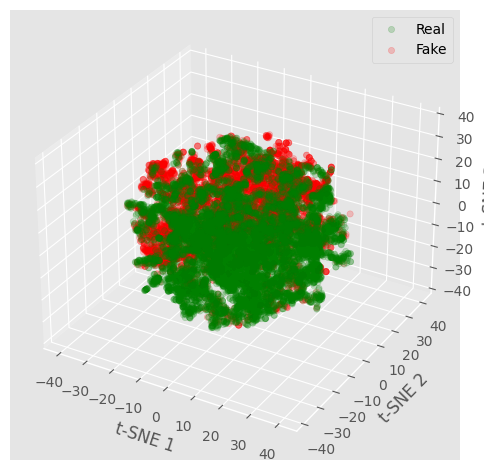

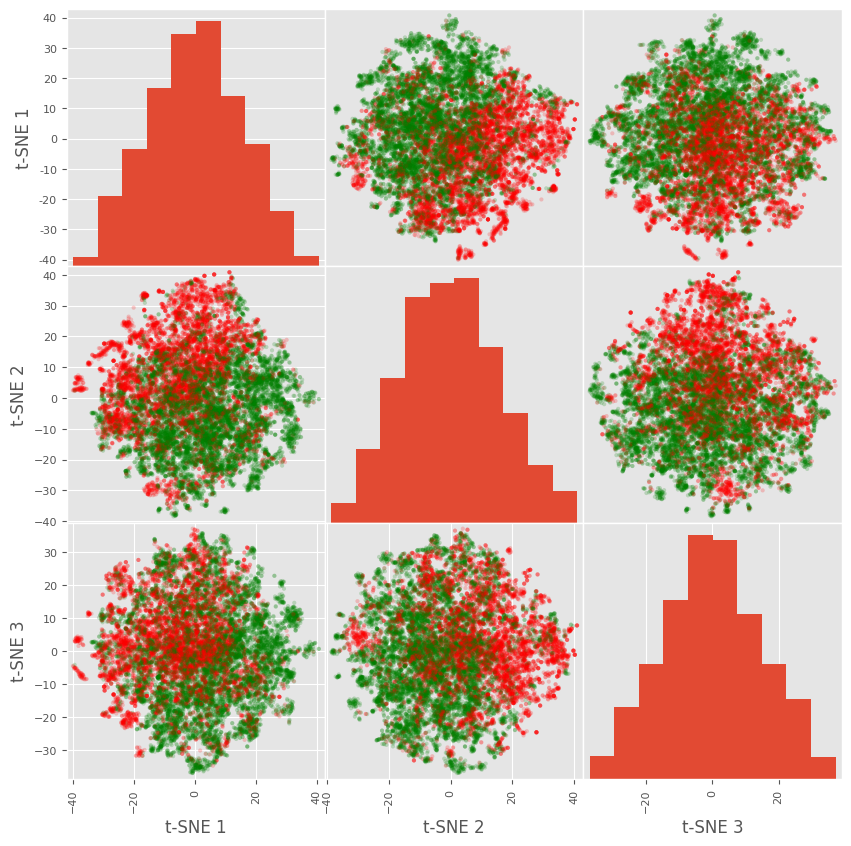

In [13]:
# from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
# %matplotlib qt
%matplotlib inline

# dataset = 'BuzzFeed'
dataset = 'large'

# Load precomputed LSA matrix
lsa_matrix              = np.load(DATA_DIR / f'processed/FakeNewsNet/{dataset}_lsa-matrix.npz', allow_pickle=True)['lsa_matrix']
# Load pre-computed t-SNE features
tsne_features           = np.load(DATA_DIR / f'processed/FakeNewsNet/{dataset}_tsne-features.npz', allow_pickle=True)['tsne_features']
tsne_features           = pd.DataFrame(tsne_features)
tsne_features['label']  = df_kaggle['label'].map({0: 'Real', 1: 'Fake'})
tsne_features           = tsne_features.rename(columns={0: 't-SNE 1', 1: 't-SNE 2', 2: 't-SNE 3'})

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = {'Real': 'g', 'Fake': 'r'}
for label, color in colors.items():
    ax.scatter(tsne_features.query('label == @label').iloc[:, 0], tsne_features.query('label == @label').iloc[:, 1], tsne_features.query('label == @label').iloc[:, 2], alpha=0.8 if dataset == 'BuzzFeed' else 0.2, c=color, label=label)

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
ax.legend()
plt.tight_layout()
plt.show()

scatter_matrix(tsne_features[[f't-SNE {i+1}' for i in range(3)]], alpha=0.8 if dataset == 'BuzzFeed' else 0.2, figsize=(10, 10), diagonal='hist', c=tsne_features['label'].apply(lambda x: colors[x]))
plt.show()

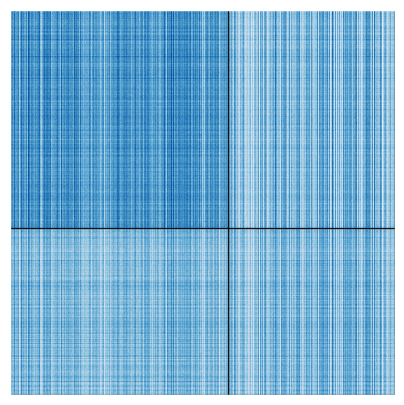

In [58]:
%matplotlib inline

A           = lsa_matrix.dot(lsa_matrix.T)

# Create dataframe
temp            = pd.DataFrame(A)
temp['label']   = df_kaggle['label']

# Visualize similarity matrix
order = temp['label'].argsort()

# Get cumulative counts
N = A.shape[0]
cum_counts_row = np.cumsum(np.unique(temp['label'], return_counts=True)[1])
cum_counts_col = np.cumsum(np.unique(temp['label'], return_counts=True)[1])

# Plot ordered similarity matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(A[order, :][:, order] > np.median(A.flatten()), cmap='Blues')
# Add lines
for l_ in range(cum_counts_row.shape[0]):
    x_, y_ = np.array([cum_counts_row[l_], cum_counts_row[l_]]), np.array([0, N])
    line = plt.Line2D(y_, x_, color='k', alpha=0.9, linewidth=1)
    ax.add_line(line)

    x_, y_ = np.array([cum_counts_col[l_], cum_counts_col[l_]]), np.array([0, N])
    line = plt.Line2D(x_, y_, color='k', alpha=0.9, linewidth=1)
    ax.add_line(line)

# plt.colorbar()
ax.grid(None)
ax.set_xticks([]); ax.set_yticks([])
plt.show()

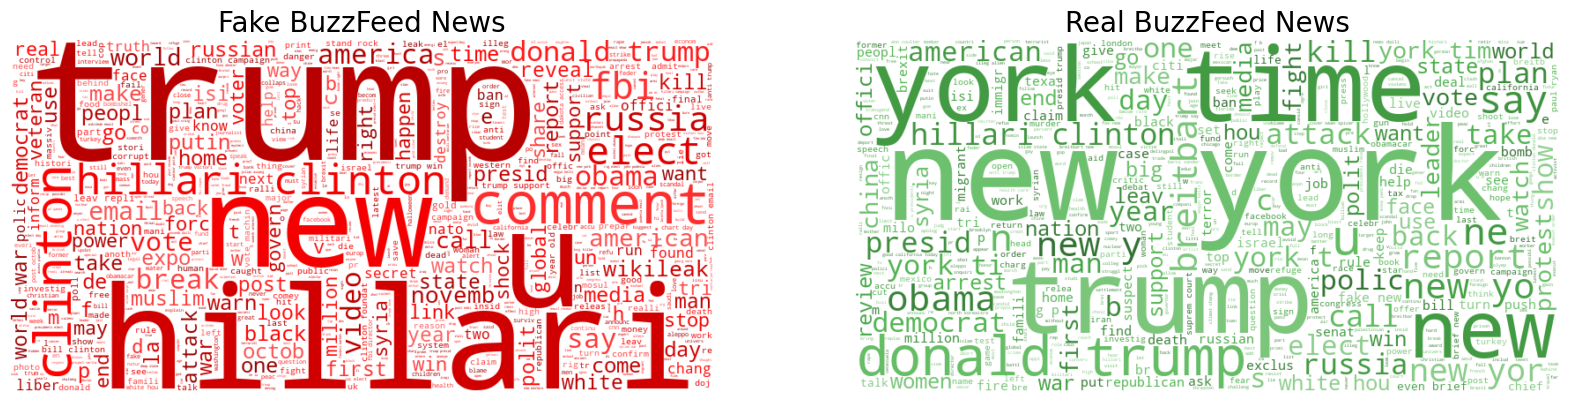

In [14]:
tokenized_text = pd.read_csv(DATA_DIR / f'processed/FakeNewsNet/large_tokenized-text.csv')

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
for label_idx, label in enumerate(tokenized_text['label'].unique()):
    # Create a word cloud for the cluster content
    wordcloud_ = WordCloud(background_color="white",
                            max_words=5000,
                            contour_width=3,
                            contour_color='steelblue',
                            color_func=red_color_func if label == 1 else green_color_func,
                            width=800,  
                            height=400  
                            ).generate(tokenized_text.query('label == @label')["tokenized_text"].to_string())
    # img = wordcloud_.to_image()
    axs[label_idx].imshow(wordcloud_, interpolation='bilinear')
    axs[label_idx].axis("off")

axs[0].set_title("Fake BuzzFeed News", fontsize=20)
axs[1].set_title("Real BuzzFeed News", fontsize=20)

# Show figure
plt.show()

del tokenized_text

<a class="anchor" id="graph-analysis"></a>
## 3. Analyzing the FakeNewsNet-BuzzFeed graph

Before further exploring the featurizer, we verify that elements such as the full graph are stored in the object and run an initial analysis of the full graph.

Is the graph fully connected: True

Number of nodes: 	182
Number of edges: 	4772
Network diameter: 	4
Average shortest path: 	1.7663
Density: 		0.2897


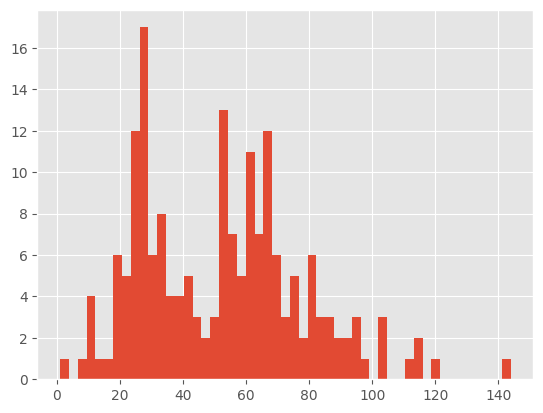

In [15]:
featurizer  = Featurizer(dataset='BuzzFeed', datapath=DATA_DIR / f'processed/FakeNewsNet', K=10)
G           = featurizer.full_graph

# Verify connectivity
print(f"Is the graph fully connected: {nx.is_connected(G)}\n")

# Network statistics
print(f"Number of nodes: \t{G.nodes().__len__()}")
print(f"Number of edges: \t{G.edges().__len__()}")
print(f"Network diameter: \t{nx.diameter(G)}")
print(f"Average shortest path: \t{nx.average_shortest_path_length(G):.4f}")
print(f"Density: \t\t{nx.density(G):.4f}")

# Degree distribution
plt.hist(dict(G.degree()).values(), bins=51)
plt.show()

As is seen, the network is quite dense in terms of links between nodes which can be seen from the degree distribution suggesting that most nodes have between 20-100 connections. This would immediately raise concerns regarding the task; namely that of predicting fake- or real news, since this could indicate that most nodes are connected to so many other nodes that there would be no clear distinction between the classes. However, visualizing the network using `netwulf` reveals a different finding, namely, that there is a somewhat apparent ground truth grouping of fake and real news with two minor intermediate groups with articles of limited degrees (size of nodes are degree). 

In [16]:
# ### UNCOMMENT TO GET GRAPH VISUALIZATION ! ### 

# # Create ground truth partition
# colors = ['green', 'red']
# fakenews_partition = [{node for node in G.nodes() if target in node} for target in ['Real', 'Fake']]

# # Retrieve color codes on the node level
# viz_partition = {}
# for i, partition_ in enumerate(tqdm(fakenews_partition)):
#     for node_ in partition_:
#         viz_partition[node_] = colors[i]

# # Set color codes on the node level
# nx.set_node_attributes(G, viz_partition, "group")

# # Visualize network
# stylized_network, config = nw.visualize(G)
# fig, ax = nw.draw_netwulf(stylized_network)
# plt.show()

In [17]:
# Other statistics (node-wise)
clustering_coefficient  = nx.clustering(G)
degree_centrality       = nx.degree_centrality(G)
betweenness_centrality  = nx.betweenness_centrality(G)
closeness_centrality    = nx.closeness_centrality(G)
eigenvector_centrality  = nx.eigenvector_centrality(G)

### Clustering - Louvain method

In [18]:
# Apply Louvain method for detecting best partition of the graph
louvain_partition       = nx.community.louvain_communities(G)
modularity              = nx.community.modularity(G, louvain_partition)
print(modularity)

0.5468606050851721


In [17]:
class KMeans_clustering:
    def __init__(self, n_clusters=2, random_state=42, max_iter=100, tol=1e-4):
        """
        Initialize the KMeans clustering model.

        Parameters:
        n_clusters (int): The number of clusters to form.
        random_state (int): Determines random number generation for centroid initialization.
        max_iter (int): Maximum number of iterations of the k-means algorithm for a single run.
        tol (float): Relative tolerance with regards to inertia to declare convergence.
        """
        self.train_centroids = None
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol = tol

    def fit_predict(self, X):
        """
        Compute k-means clustering and predict the cluster label for each sample.

        Parameters:
        X (array-like): List of n_features-dimensional data points. Each row corresponds to a single data point.

        Returns:
        cluster_labels (list of int): Predicted cluster labels for each sample.
        """
        # Create a random number generator with a specific seed
        rng = np.random.RandomState(self.random_state)

        # Initialize cluster centroids
        old_centroids = X[rng.choice(range(len(X)), size=self.n_clusters, replace=False)]
        centroids = old_centroids.copy()

        # Initialize cluster labels
        cluster_labels = np.zeros(len(X))

        # Iterate until convergence or until max_iterations is reached
        for iteration in range(self.max_iter):

            # Compute the distance between each data point and each centroid
            distances = euclidean_distances(X, centroids)

            # Assign each data point to the closest centroid
            new_cluster_labels = np.argmin(distances, axis=1)

            # Update the centroids and reinitialize empty clusters
            for c in range(self.n_clusters):
                if len(X[new_cluster_labels == c]) > 0:
                    centroids[c] = X[new_cluster_labels == c].mean(axis=0)
                else:  # reinitialize empty cluster
                    centroids[c] = X[rng.choice(range(len(X)))]

            # Check for convergence
            if np.sum((centroids - old_centroids)**2) < self.tol:
                break

            # Update the membership matrix and old centroids
            old_centroids = centroids.copy()
            cluster_labels = new_cluster_labels

        self.train_centroids = centroids

        return cluster_labels

    def predict(self, X):
        """Predict cluster labels for new data points.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row corresponds to a single data point.

        Returns
        -------
        list of int
            Predicted cluster labels for each sample.

        """
        # Compute pairwise distances between data points and cluster centroids
        distances = np.array([np.sqrt(np.sum((X - centroid)**2, axis=1)) for centroid in self.train_centroids])

        # Assign cluster labels
        cluster_labels = np.argmin(distances, axis=0)

        return cluster_labels

class DBSCAN_clustering:

    def __init__(self, eps, min_samples, metric='euclidean'):
        self.eps            = eps
        self.min_samples    = min_samples
        self.metric         = metric

    def fit(self, Xtrain: np.ndarray):
        db_sklearn = DBSCAN(eps=self.eps, min_samples=self.min_samples, metric=self.metric)
        db_sklearn.fit(Xtrain)

        # Get cluster labels for training points
        self.train_clusters                 = db_sklearn.labels_
        self.training_core_points           = Xtrain[db_sklearn.core_sample_indices_]
        self.training_core_points_labels    = db_sklearn.labels_[db_sklearn.core_sample_indices_]

        # Not counting outliers
        self.unique_db_clusters = np.unique(self.training_core_points_labels)
        # print(f"Number of unique clusters: {self.unique_db_clusters.__len__()}")
        return self.train_clusters
    
    def predict(self, Xtest: np.ndarray, batch_frac: float = 0.01, K_nearest: int = 10):

        ### AVERAGE CLUSTER DISTANCE ###
        ### Here, we constructed a function for computing the average distance to the core point of each cluster. 
        ### Initially, we faced problems regarding running time for which reason a vectorized implementation was implemented.
        ### The vectorized implementation was very memory-heavy for large datasets (i.e. constructing matrices with 22 billion parameters) for
        ### which reason we exploited mini-batching to reduce the memory load. Given the nature of DBSCAN, this approach might take long time as
        ### well, since specific settings of the epsilon parameter can possibly create a large number of small clusters.
        ### Instead, we approach the problem by considering the K-nearest core points for each test point and assign the test point to the associated cluster.
        ### In practice, we rely on the implementation of the KNeighborsClassifier from sklearn.neighbors as their implementation is rather efficient.
        
        # # Initialize cluster lists
        # num_test_points     = Xtest.shape[0]

        # core_cluster_lists  = [self.training_core_points[self.training_core_points_labels == cluster] for cluster in self.unique_db_clusters]
        # avg_distances       = np.zeros((num_test_points, self.unique_db_clusters.shape[0]))

        # # Compute average distance to the core point of each cluster using vectorization rather than a nested for-loop
        # for j, cluster in enumerate(core_cluster_lists):
        #     # Compute dynamic batch size
        #     batch_size      = np.floor(batch_frac * cluster.shape[0]).astype(int)
            
        #     # Set up batch loop
        #     batch_idx       = 0
        #     num_assigned    = 0
        #     distances       = np.zeros((num_test_points, cluster.shape[0]))
           
        #     while num_assigned < num_test_points:
        #         # Get batch of test points
        #         Xtest_          = Xtest[batch_idx*batch_size: (1+batch_idx)*batch_size, np.newaxis, :]
        #         # Compute distances
        #         # distances[batch_idx*batch_size: (1+batch_idx)*batch_size, :] = np.sqrt(np.sum((Xtest_ - cluster) ** 2, axis=2))
        #         distances[batch_idx*batch_size: (1+batch_idx)*batch_size, :] = np.sqrt(np.sum((Xtest_ - cluster) ** 2, axis=2))
                
        #         # Update convergence?
        #         num_assigned    += batch_size
        #         batch_idx       += 1

        #     # Compute average distance to core point of cluster
        #     avg_distances[:, j] = np.mean(distances, axis=1)

        # # Assign cluster labels if non-noise clusters exist
        # if self.unique_db_clusters.shape[0] == 0:
        #     test_clusters = np.array([])
        # else: 
        #     test_clusters = np.argmin(avg_distances, axis=1)

        # Fit KNN model        
        knn = KNeighborsClassifier(n_neighbors=K_nearest)
        knn.fit(self.training_core_points, self.training_core_points_labels)
        test_clusters = knn.predict(Xtest)

        return test_clusters

class EvaluationModule:
    
    def __init__(
        self,
        featurizer: Featurizer,
        model: RandomForestClassifier,
        metrics: List[str] = ['SS', 'DBI', 'CHS', 'ARI', 'NMI', 'accuracy', 'balanced_accuracy', 'weighted_f1_scores', 'precision', 'recall'],
        seed: int = 42,
    ):
        # Define featurizer and model
        self.featurizer         = featurizer
        self.model              = model
        # Setup evaluation metrics
        self.metrics            = metrics
        # Set seed
        self.seed               = seed

        # Whether run was triggered once
        self.run_count                  = 0
        self.previously_run_approaches  = []

        # Prepare prediction storage
        self.predictions        = defaultdict(dict) 
        self.true_labels        = defaultdict(dict)
        self.feature_repr       = defaultdict(dict)
        self.majority_results   = defaultdict(dict)

    def clustering(self, Xtrain, ytrain, Xtest, ytest, mode: str, **kwargs):

        info = {}
        if mode in ['KMeans', 'SpectralClustering']:
            # Define clustering model
            cls             = KMeans_clustering(n_clusters=kwargs['K_clusters'], random_state=self.seed, max_iter=100)

            # Get cluster labels
            train_clusters  = cls.fit_predict(Xtrain)
            test_clusters   = cls.predict(Xtest)
            
            # Get unique clusters
            info['unique_clusters'] = range(kwargs['K_clusters'])

        elif mode == 'DBSCAN':
            # Define clustering model
            cls = DBSCAN_clustering(eps=kwargs['eps'], min_samples=kwargs['min_samples'], metric = kwargs['metric'])
            
            # Get cluster labels
            train_clusters  = cls.fit(Xtrain)
            test_clusters   = cls.predict(Xtest)
            
            # Get unique clusters
            info['unique_clusters'] = cls.unique_db_clusters

        else:
            raise NotImplementedError('Specified clustering method not implemented!')

        return {k: [Xtrain[train_clusters == k], ytrain[train_clusters == k], Xtest[test_clusters == k], ytest[test_clusters == k]] for k in info['unique_clusters']}, info

    def fit_predict(self, feature_modes: List[str], modeling_approaches: List[str] = ['baseline', 'global'], resolution_parameter=None, model_verbose=False, **kwargs):
        """
        Fit models and get predictions according to modeling_approaches input.

        Args:
            feature_mode (str): Which feature mode to use, e.g. 'tf-idf', 'lsa' or 'node2vec'.
            modeling_approaches (List[str], optional): The approaches to run. Defaults to ['baseline', 'global'].
        """
        # We do ensemble learning if more than one feature mode is specified
        self.ensemble = feature_modes.__len__() > 1
        if self.ensemble:
            # We need nested dicts to store predictions for each feature mode
            self.predictions = defaultdict(lambda: defaultdict(dict))

        if self.run_count == 0:
            self.module_feature_mode        = feature_modes
        # else:
        #     assert feature_mode == self.module_feature_mode, "Can only run one feature mode per initialized EvaluationModule object..."

        # Run cross-validation
        info = defaultdict(dict)

        for fold in tqdm(range(self.featurizer.K), desc='RUNNING CROSS-VALIDATION...'):
            for feature_mode in feature_modes:
                Xtrain, ytrain, Xtest, ytest, feature_info = self.featurizer.get_feature_split(feature_mode=feature_mode, fold=fold, K_clusters=32 if resolution_parameter is None else resolution_parameter[0]) # when running on graph
                # Loop through experiments
                for modeling_approach in np.setdiff1d(modeling_approaches, self.previously_run_approaches):
                    if modeling_approach == 'baseline':
                        # Define majority voting baseline
                        uniques, counts                     = np.unique(ytrain, return_counts=True)
                        majority_voter                      = uniques[np.argmax(counts)]
                        # Get predictions
                        self.predictions['baseline'][fold]  = majority_voter * np.ones(ytest.shape)
                        # Store true labels
                        self.true_labels['baseline'][fold]  = ytest
                        # Store true feature representations
                        self.feature_repr['baseline'][fold] = Xtest

                    elif modeling_approach == 'global':
                        # Train model
                        self.model.fit(Xtrain, ytrain)
                        # Get predictions
                        if self.ensemble: # If ensemble, we use the class probabilities
                            self.predictions['global'][fold][feature_mode]    = self.model.predict_proba(Xtest)
                        else:
                            self.predictions['global'][fold]    = self.model.predict(Xtest)
                        # Store true labels
                        self.true_labels['global'][fold]    = ytest
                        # Store true feature representations
                        self.feature_repr['global'][fold]   = Xtest

                    else:
                        # We only do clustering for text data.
                        if feature_mode not in ["node2vec", "spectral_graph"]:
                            # Run hierarchical clustering for base (full dataset)
                            self.model.fit(Xtrain, ytrain)
                            self.predictions[(modeling_approach,  0, -1)][fold]   = self.model.predict(Xtest)
                            self.true_labels[(modeling_approach,  0, -1)][fold]   = ytest
                            self.feature_repr[(modeling_approach, 0, -1)][fold]   = Xtest
                            info[(modeling_approach, 0, fold)]['unique_clusters'] = [-1]

                            for hierarchical_level, resolution in enumerate(resolution_parameter):
                                if modeling_approach == 'SpectralClustering':
                                    # spectral clustering normalizes the rows after selecting the k largest eigenvectors, therefore it needs to be computed here...
                                    Xtrain, ytrain, Xtest, ytest, feature_info = self.featurizer.get_feature_split(feature_mode='spectral_text', fold=fold, K_clusters=resolution)

                                # Run clustering and get output
                                if modeling_approach == 'KMeans':
                                    cluster_dict, info_ = self.clustering(Xtrain, ytrain, Xtest, ytest, mode=modeling_approach, K_clusters=resolution)
                                elif modeling_approach == 'SpectralClustering':
                                    cluster_dict, info_ = self.clustering(Xtrain, ytrain, Xtest, ytest, mode=modeling_approach, K_clusters=resolution)
                                elif modeling_approach == 'DBSCAN':
                                    cluster_dict, info_ = self.clustering(Xtrain, ytrain, Xtest, ytest, mode=modeling_approach, eps=resolution[0], min_samples=resolution[1], metric=resolution[2])

                                # Store information about unique clusters
                                info[(modeling_approach, hierarchical_level+1, fold)]['unique_clusters'] = info_['unique_clusters']
                                
                                # Exploit local patterns
                                for cluster_idx, (Xtrain_c, ytrain_c, Xtest_c, ytest_c) in cluster_dict.items():
                                    # Train local model
                                    self.model.fit(Xtrain_c, ytrain_c)

                                    # Check if test-cluster is non-empty
                                    if Xtest_c.shape[0] > 0:
                                        # Store true labels and feature representations
                                        self.predictions[(modeling_approach,  hierarchical_level+1, cluster_idx)][fold]   = self.model.predict(Xtest_c)
                                        self.true_labels[(modeling_approach,  hierarchical_level+1, cluster_idx)][fold]   = ytest_c
                                        self.feature_repr[(modeling_approach, hierarchical_level+1, cluster_idx)][fold]   = Xtest_c

                                    else:
                                        # print('(', modeling_approach, cluster_idx, f' - fold {fold} ) testset is empty!')
                                        # Store true labels and feature representations
                                        self.predictions[(modeling_approach,  hierarchical_level+1, cluster_idx)][fold]   = np.array([])
                                        self.true_labels[(modeling_approach,  hierarchical_level+1, cluster_idx)][fold]   = np.array([])
                                        self.feature_repr[(modeling_approach, hierarchical_level+1, cluster_idx)][fold]   = np.empty((0, Xtrain_c.shape[1]))


        # Update already run approaches
        self.previously_run_approaches  = np.union1d(modeling_approaches, self.previously_run_approaches)
        self.store_global_clustering_predictions(info=info, resolution_parameter=resolution_parameter)
        self.majority_voting(keep=modeling_approaches, folds=range(self.featurizer.K))

        if self.ensemble:
            for fold in range(self.featurizer.K):
                for modeling_approach in np.setdiff1d(modeling_approaches, ['baseline', 'global']):
                    if "node2vec" in feature_modes:
                        self.majority_results[f'ensemble - {modeling_approach} - node2vec'][fold] = np.mean([self.majority_results[modeling_approach][fold], self.predictions["global"][fold]["node2vec"]], axis=0)

                    elif "spectral_graph" in feature_modes:
                        self.majority_results[f'ensemble - {modeling_approach} - spectral_graph'][fold] = np.mean([self.majority_results[modeling_approach][fold], self.predictions["global"][fold]["spectral_graph"]], axis=0)


    def store_global_clustering_predictions(self, **kwargs):

        if kwargs['resolution_parameter'] is not None:
            hierarchical_levels = np.arange(kwargs['resolution_parameter'].__len__()+1)

            # Add global KMeans labels to predictions
            for clustering_method in np.setdiff1d(self.previously_run_approaches, ['baseline', 'global']):
                for fold in range(self.featurizer.K):
                    for h_level in hierarchical_levels:
                        # We concatenate the predictions, true labels and feature representations for each cluster.
                        if kwargs['info'][(clustering_method, h_level, fold)]['unique_clusters'].__len__() > 0:
                            self.true_labels[(clustering_method, h_level)][fold]   = np.concatenate([self.true_labels[(clustering_method,  h_level, k)][fold] for k in kwargs['info'][(clustering_method, h_level, fold)]['unique_clusters']])
                            self.feature_repr[(clustering_method, h_level)][fold]  = np.concatenate([self.feature_repr[(clustering_method, h_level, k)][fold] for k in kwargs['info'][(clustering_method, h_level, fold)]['unique_clusters']])
                            # If ensemble, the within cluster predictions have already been concatenated and stored in the predictions dict.
                            self.predictions[(clustering_method, h_level)][fold]   = np.concatenate([self.predictions[(clustering_method,  h_level, k)][fold] for k in kwargs['info'][(clustering_method, h_level, fold)]['unique_clusters']])
                        else:
                            self.true_labels[(clustering_method, h_level)][fold]   = np.array([])
                            self.feature_repr[(clustering_method, h_level)][fold]  = np.array([])
                            self.predictions[(clustering_method, h_level)][fold]   = np.ones(len(self.predictions['baseline'][fold]))*np.nan
                            
    def majority_voting(self, keep, folds):
        for fold in folds:
            # Restore modeling approaches that has no granularity
            if 'baseline' in keep:
                self.majority_results['baseline'][fold]  = self.predictions['baseline'][fold]
            if 'global' in keep:
                self.majority_results['global'][fold]    = self.predictions['global'][fold]

            # Iterate through modeling approaches that has granularity
            for attr in np.setdiff1d(keep, ['baseline', 'global']):
                attr_hierarchical = []
                for key, predictions in self.predictions.items():
                    if attr in key and key.__len__() == 2:
                        attr_hierarchical.append(predictions[fold])

                # Majority vote
                if self.ensemble:
                    self.majority_results[attr][fold] = np.vstack([1-np.mean(attr_hierarchical, axis=0), np.mean(attr_hierarchical, axis=0)]).T
                else:
                    self.majority_results[attr][fold] = (np.nanmean(attr_hierarchical, axis=0) > 0.5).astype(int)

    def get_performance(self, keep=None, **kwargs):
        results = defaultdict(dict)
        for fold in range(self.featurizer.K):

            # Store results
            results_fold = {}
            attributes   = keep if keep is not None else self.majority_results.keys()
            # Iterate through modeling approaches
            for modeling_approach in attributes:
                if "ensemble" in modeling_approach:
                    ypred = np.argmax(self.majority_results[modeling_approach][fold], axis=1)
                else:
                    ypred = self.majority_results[modeling_approach][fold]

                # Get test set
                Xtest = self.feature_repr['baseline'][fold]
                ytest = self.true_labels['baseline'][fold]

                # Make sure that ytest and ypred are of the same 1D shape
                ypred = ypred.ravel()

                # Compute and store results
                results_fold[modeling_approach] = {}
                results_fold[modeling_approach]['SS']                = silhouette_score(Xtest, ypred) if np.unique(ypred).__len__() > 1 and len(ypred) > 2 else None
                results_fold[modeling_approach]['DBI']               = davies_bouldin_score(Xtest, ypred) if np.unique(ypred).__len__() > 1 and len(ypred) > 2 else None
                results_fold[modeling_approach]['CHS']               = calinski_harabasz_score(Xtest, ypred) if np.unique(ypred).__len__() > 1 and len(ypred) > 2 else None
                results_fold[modeling_approach]['ARI']               = adjusted_rand_score(ytest, ypred)
                results_fold[modeling_approach]['NMI']               = normalized_mutual_info_score(ytest, ypred)
                results_fold[modeling_approach]['accuracy']          = np.mean(ytest == ypred)
                results_fold[modeling_approach]['balanced_accuracy'] = balanced_accuracy_score(ytest, ypred)
                results_fold[modeling_approach]['weighted_f1_score'] = f1_score(ytest, ypred, average='weighted')
                results_fold[modeling_approach]['precision']         = precision_score(ytest, ypred, average='weighted', zero_division=0.0)
                results_fold[modeling_approach]['recall']            = recall_score(ytest, ypred, average='weighted', zero_division=1.0)

            results[fold] = pd.DataFrame(results_fold)

        return results

    def latex_results(self, results, n_floats=2):

        # Compute mean and sem across folds
        results_    = np.stack([results[fold].to_numpy() for fold in range(self.featurizer.K)])
        mean_       = np.nanmean(results_, axis = 0)# .replace(np.inf, np.nan)
        sems_       = np.nanstd(np.stack([results[fold].to_numpy() for fold in range(self.featurizer.K)]), axis=0) / np.sqrt(self.featurizer.K)

        # Reformat as strings for proper latex display
        latex = np.ones(mean_.shape).astype(str)
        for i in range(mean_.shape[0]):
            for j in range(mean_.shape[1]):
                latex[i, j] = f"${mean_[i,j]:.{n_floats}f} \pm {sems_[i,j]:.{n_floats}f}$"

        # Create dataframe
        df_latex    = pd.DataFrame(latex, columns=results[0].columns, index=results[0].index)
        mean_       = pd.DataFrame(mean_, columns=results[0].columns, index=results[0].index)
        sems_       = pd.DataFrame(sems_, columns=results[0].columns, index=results[0].index)

        return df_latex, mean_, sems_

### Running results on FakeNewsKaggle dataset

[Link to dataset](https://www.kaggle.com/c/fake-news)

At first, we optimize the depth of the hierarchical classification approach by adjusting the number of layers and the width of the layers. Below, we run using a sort of grid-search approach to get the optimal parameter setting for hierarchical classification using KMeans.

In [45]:
featurizer  = Featurizer(dataset='FakeNewsKaggle', datapath=DATA_DIR / f'processed/FakeNewsNet', K=5)

# KMeans optimization results loop
for i, resolution_parameter_ in enumerate(tqdm([[2], [4], [6], [2, 4], [2, 6], [2, 4, 6], [2, 4, 8], [2, 4, 6, 8]], desc='OPTIMIZING KMEANS RESOLUTION...')):
    np.random.seed(0)
    
    KMEANS_evaluator   = EvaluationModule(
        featurizer=featurizer,
        model=RandomForestClassifier(n_estimators=20, random_state=42, verbose=0, n_jobs=-1),
    )

    KMEANS_evaluator.fit_predict(feature_modes=['lsa'], modeling_approaches=['baseline', 'global', 'KMeans'], resolution_parameter=resolution_parameter_)

    with warnings.catch_warnings():
        # NaN warning occurs for one of the metris but this is as expected, hence, we ignore it.
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        res      = KMEANS_evaluator.get_performance(keep=['baseline', 'global', 'KMeans'], folds=range(featurizer.K))
        res, _, _= KMEANS_evaluator.latex_results(res)

    if i == 0:
        results = res.rename(columns={'KMeans': str(resolution_parameter_)})
    else:
        results[str(resolution_parameter_)] = res['KMeans'].values

del KMEANS_evaluator

# Print results
print(results.to_latex())
results

Loading pre-computed TF-IDF matrix...
Loaded TF-IDF matrix of shape (18285, 124742) from disk!


OPTIMIZING KMEANS RESOLUTION...: 100%|██████████| 8/8 [10:52<00:00, 81.62s/it]


,baseline,global,[2],[4],[6],"[2, 4]","[2, 6]","[2, 4, 6]","[2, 4, 8]","[2, 4, 6, 8]"
SS,nan \pm nan,0.011 \pm 0.000,0.003 \pm 0.001,0.002 \pm 0.001,0.002 \pm 0.000,0.003 \pm 0.001,0.003 \pm 0.001,0.002 \pm 0.000,0.002 \pm 0.000,0.001 \pm 0.001
DBI,nan \pm nan,9.288 \pm 0.056,14.165 \pm 0.079,14.667 \pm 0.276,14.337 \pm 0.135,17.737 \pm 0.245,17.880 \pm 0.304,21.262 \pm 0.346,21.262 \pm 0.292,23.348 \pm 0.281
CHS,nan \pm nan,36.702 \pm 0.503,14.315 \pm 0.277,13.365 \pm 0.448,13.989 \pm 0.333,9.800 \pm 0.258,9.596 \pm 0.270,7.073 \pm 0.254,7.059 \pm 0.212,5.510 \pm 0.136
ARI,0.000 \pm 0.000,0.616 \pm 0.008,0.162 \pm 0.007,0.148 \pm 0.002,0.156 \pm 0.002,0.168 \pm 0.007,0.163 \pm 0.005,0.092 \pm 0.005,0.093 \pm 0.005,0.094 \pm 0.003
NMI,0.000 \pm 0.000,0.503 \pm 0.008,0.197 \pm 0.004,0.182 \pm 0.004,0.189 \pm 0.002,0.118 \pm 0.005,0.113 \pm 0.004,0.080 \pm 0.003,0.082 \pm 0.003,0.061 \pm 0.002
accuracy,0.567 \pm 0.002,0.893 \pm 0.003,0.702 \pm 0.004,0.694 \pm 0.002,0.698 \pm 0.001,0.706 \pm 0.004,0.702 \pm 0.003,0.651 \pm 0.004,0.653 \pm 0.004,0.654 \pm 0.002
balanced_accuracy,0.500 \pm 0.000,0.889 \pm 0.003,0.728 \pm 0.004,0.720 \pm 0.001,0.724 \pm 0.002,0.694 \pm 0.003,0.690 \pm 0.003,0.663 \pm 0.003,0.664 \pm 0.003,0.639 \pm 0.002
weighted_f1_score,0.410 \pm 0.002,0.892 \pm 0.003,0.695 \pm 0.005,0.686 \pm 0.001,0.691 \pm 0.002,0.703 \pm 0.004,0.699 \pm 0.003,0.651 \pm 0.004,0.653 \pm 0.004,0.649 \pm 0.002
precision,0.321 \pm 0.002,0.892 \pm 0.003,0.772 \pm 0.002,0.764 \pm 0.002,0.768 \pm 0.001,0.704 \pm 0.004,0.700 \pm 0.003,0.675 \pm 0.003,0.676 \pm 0.003,0.651 \pm 0.002
recall,0.567 \pm 0.002,0.893 \pm 0.003,0.702 \pm 0.004,0.694 \pm 0.002,0.698 \pm 0.001,0.706 \pm 0.004,0.702 \pm 0.003,0.651 \pm 0.004,0.653 \pm 0.004,0.654 \pm 0.002


In [9]:
featurizer  = Featurizer(dataset='FakeNewsKaggle', datapath=DATA_DIR / f'processed/FakeNewsNet', K=5)

# 0.50 is approx. 20 clusters, 0.75 is approx. 4-5 clusters, 0.8 is approx. 2-3 clusters, 1.00 is approx. 1 cluster
optimization_resolutions_ = [
    [(0.80, 3, 'euclidean')],
    [(0.75, 3, 'euclidean')],
    [(0.50, 3, 'euclidean')], 
    [(0.80, 3, 'euclidean'), (0.75, 3, 'euclidean')],
    [(0.80, 3, 'euclidean'), (0.50, 3, 'euclidean')],
    [(0.75, 3, 'euclidean'), (0.50, 3, 'euclidean')],
    [(0.80, 3, 'euclidean'), (0.75, 3, 'euclidean'), (0.500, 3, 'euclidean')],
    [(0.80, 3, 'euclidean'), (0.75, 3, 'euclidean'), (0.675, 3, 'euclidean'), (0.60, 3, 'euclidean'), (0.50, 3, 'euclidean')],
]

# DBSCAN optimization results loop
for i, resolution_parameter_ in enumerate(tqdm(optimization_resolutions_, desc='OPTIMIZING DBSCAN RESOLUTION...')):
    np.random.seed(0)
    
    DBSCAN_evaluator   = EvaluationModule(
        featurizer=featurizer,
        model=RandomForestClassifier(n_estimators=20, random_state=42, verbose=0, n_jobs=-1),
    )

    DBSCAN_evaluator.fit_predict(feature_modes=['lsa'], modeling_approaches=['baseline', 'global', 'DBSCAN'], resolution_parameter=resolution_parameter_)

    with warnings.catch_warnings():
        # NaN warning occurs for one of the metris but this is as expected, hence, we ignore it.
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        res      = DBSCAN_evaluator.get_performance(keep=['baseline', 'global', 'DBSCAN'], folds=range(featurizer.K))
        res, _, _= DBSCAN_evaluator.latex_results(res)

    if i == 0:
        results = res.rename(columns={'DBSCAN': str(resolution_parameter_)})
    else:
        results[str(resolution_parameter_)] = res['DBSCAN'].values

del DBSCAN_evaluator
print(results.to_latex())
results

Loading pre-computed TF-IDF matrix...
Loaded TF-IDF matrix of shape (18285, 124742) from disk!


OPTIMIZING DBSCAN RESOLUTION...:   0%|          | 0/8 [00:00<?, ?it/s]

Number of unique clusters: 2


Number of unique clusters: 2


Number of unique clusters: 2


Number of unique clusters: 3


Number of unique clusters: 2


OPTIMIZING DBSCAN RESOLUTION...:  12%|█▎        | 1/8 [02:12<15:28, 132.71s/it]

Number of unique clusters: 5
( DBSCAN 4  - fold 0 ) testset is empty!


Number of unique clusters: 4


Number of unique clusters: 4


Number of unique clusters: 4


Number of unique clusters: 4


OPTIMIZING DBSCAN RESOLUTION...:  25%|██▌       | 2/8 [04:12<12:29, 124.89s/it]

Number of unique clusters: 20
( DBSCAN 3  - fold 0 ) testset is empty!
( DBSCAN 7  - fold 0 ) testset is empty!
( DBSCAN 9  - fold 0 ) testset is empty!
( DBSCAN 10  - fold 0 ) testset is empty!
( DBSCAN 11  - fold 0 ) testset is empty!
( DBSCAN 13  - fold 0 ) testset is empty!
( DBSCAN 14  - fold 0 ) testset is empty!
( DBSCAN 15  - fold 0 ) testset is empty!
( DBSCAN 17  - fold 0 ) testset is empty!
( DBSCAN 18  - fold 0 ) testset is empty!
( DBSCAN 19  - fold 0 ) testset is empty!


Number of unique clusters: 19
( DBSCAN 3  - fold 1 ) testset is empty!
( DBSCAN 4  - fold 1 ) testset is empty!
( DBSCAN 7  - fold 1 ) testset is empty!
( DBSCAN 10  - fold 1 ) testset is empty!
( DBSCAN 12  - fold 1 ) testset is empty!
( DBSCAN 13  - fold 1 ) testset is empty!
( DBSCAN 14  - fold 1 ) testset is empty!
( DBSCAN 15  - fold 1 ) testset is empty!
( DBSCAN 16  - fold 1 ) testset is empty!
( DBSCAN 17  - fold 1 ) testset is empty!
( DBSCAN 18  - fold 1 ) testset is empty!


Number of unique clusters: 20
( DBSCAN 4  - fold 2 ) testset is empty!
( DBSCAN 8  - fold 2 ) testset is empty!
( DBSCAN 11  - fold 2 ) testset is empty!
( DBSCAN 12  - fold 2 ) testset is empty!
( DBSCAN 14  - fold 2 ) testset is empty!
( DBSCAN 15  - fold 2 ) testset is empty!
( DBSCAN 16  - fold 2 ) testset is empty!
( DBSCAN 17  - fold 2 ) testset is empty!
( DBSCAN 18  - fold 2 ) testset is empty!
( DBSCAN 19  - fold 2 ) testset is empty!


Number of unique clusters: 19
( DBSCAN 3  - fold 3 ) testset is empty!
( DBSCAN 4  - fold 3 ) testset is empty!
( DBSCAN 8  - fold 3 ) testset is empty!
( DBSCAN 10  - fold 3 ) testset is empty!
( DBSCAN 11  - fold 3 ) testset is empty!
( DBSCAN 12  - fold 3 ) testset is empty!
( DBSCAN 13  - fold 3 ) testset is empty!
( DBSCAN 14  - fold 3 ) testset is empty!
( DBSCAN 15  - fold 3 ) testset is empty!
( DBSCAN 16  - fold 3 ) testset is empty!
( DBSCAN 17  - fold 3 ) testset is empty!
( DBSCAN 18  - fold 3 ) testset is empty!


Number of unique clusters: 22
( DBSCAN 2  - fold 4 ) testset is empty!
( DBSCAN 4  - fold 4 ) testset is empty!
( DBSCAN 6  - fold 4 ) testset is empty!
( DBSCAN 9  - fold 4 ) testset is empty!
( DBSCAN 11  - fold 4 ) testset is empty!
( DBSCAN 13  - fold 4 ) testset is empty!
( DBSCAN 15  - fold 4 ) testset is empty!
( DBSCAN 16  - fold 4 ) testset is empty!
( DBSCAN 17  - fold 4 ) testset is empty!
( DBSCAN 18  - fold 4 ) testset is empty!
( DBSCAN 20  - fold 4 ) testset is empty!
( DBSCAN 21  - fold 4 ) testset is empty!


OPTIMIZING DBSCAN RESOLUTION...:  38%|███▊      | 3/8 [05:30<08:38, 103.64s/it]

Number of unique clusters: 2
Number of unique clusters: 5
( DBSCAN 4  - fold 0 ) testset is empty!


Number of unique clusters: 2
Number of unique clusters: 4


Number of unique clusters: 2
Number of unique clusters: 4


Number of unique clusters: 3
Number of unique clusters: 4


Number of unique clusters: 2
Number of unique clusters: 4


OPTIMIZING DBSCAN RESOLUTION...:  50%|█████     | 4/8 [08:30<08:55, 133.99s/it]

Number of unique clusters: 2
Number of unique clusters: 20
( DBSCAN 3  - fold 0 ) testset is empty!
( DBSCAN 7  - fold 0 ) testset is empty!
( DBSCAN 9  - fold 0 ) testset is empty!
( DBSCAN 10  - fold 0 ) testset is empty!
( DBSCAN 11  - fold 0 ) testset is empty!
( DBSCAN 13  - fold 0 ) testset is empty!
( DBSCAN 14  - fold 0 ) testset is empty!
( DBSCAN 15  - fold 0 ) testset is empty!
( DBSCAN 17  - fold 0 ) testset is empty!
( DBSCAN 18  - fold 0 ) testset is empty!
( DBSCAN 19  - fold 0 ) testset is empty!


Number of unique clusters: 2
Number of unique clusters: 19
( DBSCAN 3  - fold 1 ) testset is empty!
( DBSCAN 4  - fold 1 ) testset is empty!
( DBSCAN 7  - fold 1 ) testset is empty!
( DBSCAN 10  - fold 1 ) testset is empty!
( DBSCAN 12  - fold 1 ) testset is empty!
( DBSCAN 13  - fold 1 ) testset is empty!
( DBSCAN 14  - fold 1 ) testset is empty!
( DBSCAN 15  - fold 1 ) testset is empty!
( DBSCAN 16  - fold 1 ) testset is empty!
( DBSCAN 17  - fold 1 ) testset is empty!
( DBSCAN 18  - fold 1 ) testset is empty!


Number of unique clusters: 2
Number of unique clusters: 20
( DBSCAN 4  - fold 2 ) testset is empty!
( DBSCAN 8  - fold 2 ) testset is empty!
( DBSCAN 11  - fold 2 ) testset is empty!
( DBSCAN 12  - fold 2 ) testset is empty!
( DBSCAN 14  - fold 2 ) testset is empty!
( DBSCAN 15  - fold 2 ) testset is empty!
( DBSCAN 16  - fold 2 ) testset is empty!
( DBSCAN 17  - fold 2 ) testset is empty!
( DBSCAN 18  - fold 2 ) testset is empty!
( DBSCAN 19  - fold 2 ) testset is empty!


Number of unique clusters: 3
Number of unique clusters: 19
( DBSCAN 3  - fold 3 ) testset is empty!
( DBSCAN 4  - fold 3 ) testset is empty!
( DBSCAN 8  - fold 3 ) testset is empty!
( DBSCAN 10  - fold 3 ) testset is empty!
( DBSCAN 11  - fold 3 ) testset is empty!
( DBSCAN 12  - fold 3 ) testset is empty!
( DBSCAN 13  - fold 3 ) testset is empty!
( DBSCAN 14  - fold 3 ) testset is empty!
( DBSCAN 15  - fold 3 ) testset is empty!
( DBSCAN 16  - fold 3 ) testset is empty!
( DBSCAN 17  - fold 3 ) testset is empty!
( DBSCAN 18  - fold 3 ) testset is empty!


Number of unique clusters: 2
Number of unique clusters: 22
( DBSCAN 2  - fold 4 ) testset is empty!
( DBSCAN 4  - fold 4 ) testset is empty!
( DBSCAN 6  - fold 4 ) testset is empty!
( DBSCAN 9  - fold 4 ) testset is empty!
( DBSCAN 11  - fold 4 ) testset is empty!
( DBSCAN 13  - fold 4 ) testset is empty!
( DBSCAN 15  - fold 4 ) testset is empty!
( DBSCAN 16  - fold 4 ) testset is empty!
( DBSCAN 17  - fold 4 ) testset is empty!
( DBSCAN 18  - fold 4 ) testset is empty!
( DBSCAN 20  - fold 4 ) testset is empty!
( DBSCAN 21  - fold 4 ) testset is empty!


OPTIMIZING DBSCAN RESOLUTION...:  62%|██████▎   | 5/8 [10:50<06:48, 136.13s/it]

Number of unique clusters: 5
( DBSCAN 4  - fold 0 ) testset is empty!
Number of unique clusters: 20
( DBSCAN 3  - fold 0 ) testset is empty!
( DBSCAN 7  - fold 0 ) testset is empty!
( DBSCAN 9  - fold 0 ) testset is empty!
( DBSCAN 10  - fold 0 ) testset is empty!
( DBSCAN 11  - fold 0 ) testset is empty!
( DBSCAN 13  - fold 0 ) testset is empty!
( DBSCAN 14  - fold 0 ) testset is empty!
( DBSCAN 15  - fold 0 ) testset is empty!
( DBSCAN 17  - fold 0 ) testset is empty!
( DBSCAN 18  - fold 0 ) testset is empty!
( DBSCAN 19  - fold 0 ) testset is empty!


Number of unique clusters: 4
Number of unique clusters: 19
( DBSCAN 3  - fold 1 ) testset is empty!
( DBSCAN 4  - fold 1 ) testset is empty!
( DBSCAN 7  - fold 1 ) testset is empty!
( DBSCAN 10  - fold 1 ) testset is empty!
( DBSCAN 12  - fold 1 ) testset is empty!
( DBSCAN 13  - fold 1 ) testset is empty!
( DBSCAN 14  - fold 1 ) testset is empty!
( DBSCAN 15  - fold 1 ) testset is empty!
( DBSCAN 16  - fold 1 ) testset is empty!
( DBSCAN 17  - fold 1 ) testset is empty!
( DBSCAN 18  - fold 1 ) testset is empty!


Number of unique clusters: 4
Number of unique clusters: 20
( DBSCAN 4  - fold 2 ) testset is empty!
( DBSCAN 8  - fold 2 ) testset is empty!
( DBSCAN 11  - fold 2 ) testset is empty!
( DBSCAN 12  - fold 2 ) testset is empty!
( DBSCAN 14  - fold 2 ) testset is empty!
( DBSCAN 15  - fold 2 ) testset is empty!
( DBSCAN 16  - fold 2 ) testset is empty!
( DBSCAN 17  - fold 2 ) testset is empty!
( DBSCAN 18  - fold 2 ) testset is empty!
( DBSCAN 19  - fold 2 ) testset is empty!


Number of unique clusters: 4
Number of unique clusters: 19
( DBSCAN 3  - fold 3 ) testset is empty!
( DBSCAN 4  - fold 3 ) testset is empty!
( DBSCAN 8  - fold 3 ) testset is empty!
( DBSCAN 10  - fold 3 ) testset is empty!
( DBSCAN 11  - fold 3 ) testset is empty!
( DBSCAN 12  - fold 3 ) testset is empty!
( DBSCAN 13  - fold 3 ) testset is empty!
( DBSCAN 14  - fold 3 ) testset is empty!
( DBSCAN 15  - fold 3 ) testset is empty!
( DBSCAN 16  - fold 3 ) testset is empty!
( DBSCAN 17  - fold 3 ) testset is empty!
( DBSCAN 18  - fold 3 ) testset is empty!


Number of unique clusters: 4
Number of unique clusters: 22
( DBSCAN 2  - fold 4 ) testset is empty!
( DBSCAN 4  - fold 4 ) testset is empty!
( DBSCAN 6  - fold 4 ) testset is empty!
( DBSCAN 9  - fold 4 ) testset is empty!
( DBSCAN 11  - fold 4 ) testset is empty!
( DBSCAN 13  - fold 4 ) testset is empty!
( DBSCAN 15  - fold 4 ) testset is empty!
( DBSCAN 16  - fold 4 ) testset is empty!
( DBSCAN 17  - fold 4 ) testset is empty!
( DBSCAN 18  - fold 4 ) testset is empty!
( DBSCAN 20  - fold 4 ) testset is empty!
( DBSCAN 21  - fold 4 ) testset is empty!


OPTIMIZING DBSCAN RESOLUTION...:  75%|███████▌  | 6/8 [13:25<04:44, 142.48s/it]

Number of unique clusters: 2
Number of unique clusters: 5
( DBSCAN 4  - fold 0 ) testset is empty!
Number of unique clusters: 20
( DBSCAN 3  - fold 0 ) testset is empty!
( DBSCAN 7  - fold 0 ) testset is empty!
( DBSCAN 9  - fold 0 ) testset is empty!
( DBSCAN 10  - fold 0 ) testset is empty!
( DBSCAN 11  - fold 0 ) testset is empty!
( DBSCAN 13  - fold 0 ) testset is empty!
( DBSCAN 14  - fold 0 ) testset is empty!
( DBSCAN 15  - fold 0 ) testset is empty!
( DBSCAN 17  - fold 0 ) testset is empty!
( DBSCAN 18  - fold 0 ) testset is empty!
( DBSCAN 19  - fold 0 ) testset is empty!


Number of unique clusters: 2
Number of unique clusters: 4
Number of unique clusters: 19
( DBSCAN 3  - fold 1 ) testset is empty!
( DBSCAN 4  - fold 1 ) testset is empty!
( DBSCAN 7  - fold 1 ) testset is empty!
( DBSCAN 10  - fold 1 ) testset is empty!
( DBSCAN 12  - fold 1 ) testset is empty!
( DBSCAN 13  - fold 1 ) testset is empty!
( DBSCAN 14  - fold 1 ) testset is empty!
( DBSCAN 15  - fold 1 ) testset is empty!
( DBSCAN 16  - fold 1 ) testset is empty!
( DBSCAN 17  - fold 1 ) testset is empty!
( DBSCAN 18  - fold 1 ) testset is empty!


Number of unique clusters: 2
Number of unique clusters: 4
Number of unique clusters: 20
( DBSCAN 4  - fold 2 ) testset is empty!
( DBSCAN 8  - fold 2 ) testset is empty!
( DBSCAN 11  - fold 2 ) testset is empty!
( DBSCAN 12  - fold 2 ) testset is empty!
( DBSCAN 14  - fold 2 ) testset is empty!
( DBSCAN 15  - fold 2 ) testset is empty!
( DBSCAN 16  - fold 2 ) testset is empty!
( DBSCAN 17  - fold 2 ) testset is empty!
( DBSCAN 18  - fold 2 ) testset is empty!
( DBSCAN 19  - fold 2 ) testset is empty!


Number of unique clusters: 3
Number of unique clusters: 4
Number of unique clusters: 19
( DBSCAN 3  - fold 3 ) testset is empty!
( DBSCAN 4  - fold 3 ) testset is empty!
( DBSCAN 8  - fold 3 ) testset is empty!
( DBSCAN 10  - fold 3 ) testset is empty!
( DBSCAN 11  - fold 3 ) testset is empty!
( DBSCAN 12  - fold 3 ) testset is empty!
( DBSCAN 13  - fold 3 ) testset is empty!
( DBSCAN 14  - fold 3 ) testset is empty!
( DBSCAN 15  - fold 3 ) testset is empty!
( DBSCAN 16  - fold 3 ) testset is empty!
( DBSCAN 17  - fold 3 ) testset is empty!
( DBSCAN 18  - fold 3 ) testset is empty!


Number of unique clusters: 2
Number of unique clusters: 4
Number of unique clusters: 22
( DBSCAN 2  - fold 4 ) testset is empty!
( DBSCAN 4  - fold 4 ) testset is empty!
( DBSCAN 6  - fold 4 ) testset is empty!
( DBSCAN 9  - fold 4 ) testset is empty!
( DBSCAN 11  - fold 4 ) testset is empty!
( DBSCAN 13  - fold 4 ) testset is empty!
( DBSCAN 15  - fold 4 ) testset is empty!
( DBSCAN 16  - fold 4 ) testset is empty!
( DBSCAN 17  - fold 4 ) testset is empty!
( DBSCAN 18  - fold 4 ) testset is empty!
( DBSCAN 20  - fold 4 ) testset is empty!
( DBSCAN 21  - fold 4 ) testset is empty!


OPTIMIZING DBSCAN RESOLUTION...:  88%|████████▊ | 7/8 [17:08<02:48, 168.87s/it]

Number of unique clusters: 2
Number of unique clusters: 5
( DBSCAN 4  - fold 0 ) testset is empty!
Number of unique clusters: 7
( DBSCAN 5  - fold 0 ) testset is empty!
Number of unique clusters: 8
( DBSCAN 5  - fold 0 ) testset is empty!
( DBSCAN 6  - fold 0 ) testset is empty!
Number of unique clusters: 20
( DBSCAN 3  - fold 0 ) testset is empty!
( DBSCAN 7  - fold 0 ) testset is empty!
( DBSCAN 9  - fold 0 ) testset is empty!
( DBSCAN 10  - fold 0 ) testset is empty!
( DBSCAN 11  - fold 0 ) testset is empty!
( DBSCAN 13  - fold 0 ) testset is empty!
( DBSCAN 14  - fold 0 ) testset is empty!
( DBSCAN 15  - fold 0 ) testset is empty!
( DBSCAN 17  - fold 0 ) testset is empty!
( DBSCAN 18  - fold 0 ) testset is empty!
( DBSCAN 19  - fold 0 ) testset is empty!


Number of unique clusters: 2
Number of unique clusters: 4
Number of unique clusters: 6
Number of unique clusters: 7
( DBSCAN 5  - fold 1 ) testset is empty!
Number of unique clusters: 19
( DBSCAN 3  - fold 1 ) testset is empty!
( DBSCAN 4  - fold 1 ) testset is empty!
( DBSCAN 7  - fold 1 ) testset is empty!
( DBSCAN 10  - fold 1 ) testset is empty!
( DBSCAN 12  - fold 1 ) testset is empty!
( DBSCAN 13  - fold 1 ) testset is empty!
( DBSCAN 14  - fold 1 ) testset is empty!
( DBSCAN 15  - fold 1 ) testset is empty!
( DBSCAN 16  - fold 1 ) testset is empty!
( DBSCAN 17  - fold 1 ) testset is empty!
( DBSCAN 18  - fold 1 ) testset is empty!


Number of unique clusters: 2
Number of unique clusters: 4
Number of unique clusters: 6
Number of unique clusters: 7
( DBSCAN 5  - fold 2 ) testset is empty!
Number of unique clusters: 20
( DBSCAN 4  - fold 2 ) testset is empty!
( DBSCAN 8  - fold 2 ) testset is empty!
( DBSCAN 11  - fold 2 ) testset is empty!
( DBSCAN 12  - fold 2 ) testset is empty!
( DBSCAN 14  - fold 2 ) testset is empty!
( DBSCAN 15  - fold 2 ) testset is empty!
( DBSCAN 16  - fold 2 ) testset is empty!
( DBSCAN 17  - fold 2 ) testset is empty!
( DBSCAN 18  - fold 2 ) testset is empty!
( DBSCAN 19  - fold 2 ) testset is empty!


Number of unique clusters: 3
Number of unique clusters: 4
Number of unique clusters: 6
Number of unique clusters: 8
( DBSCAN 6  - fold 3 ) testset is empty!
( DBSCAN 7  - fold 3 ) testset is empty!
Number of unique clusters: 19
( DBSCAN 3  - fold 3 ) testset is empty!
( DBSCAN 4  - fold 3 ) testset is empty!
( DBSCAN 8  - fold 3 ) testset is empty!
( DBSCAN 10  - fold 3 ) testset is empty!
( DBSCAN 11  - fold 3 ) testset is empty!
( DBSCAN 12  - fold 3 ) testset is empty!
( DBSCAN 13  - fold 3 ) testset is empty!
( DBSCAN 14  - fold 3 ) testset is empty!
( DBSCAN 15  - fold 3 ) testset is empty!
( DBSCAN 16  - fold 3 ) testset is empty!
( DBSCAN 17  - fold 3 ) testset is empty!
( DBSCAN 18  - fold 3 ) testset is empty!


Number of unique clusters: 2
Number of unique clusters: 4
Number of unique clusters: 6
Number of unique clusters: 8
( DBSCAN 5  - fold 4 ) testset is empty!
( DBSCAN 6  - fold 4 ) testset is empty!
Number of unique clusters: 22
( DBSCAN 2  - fold 4 ) testset is empty!
( DBSCAN 4  - fold 4 ) testset is empty!
( DBSCAN 6  - fold 4 ) testset is empty!
( DBSCAN 9  - fold 4 ) testset is empty!
( DBSCAN 11  - fold 4 ) testset is empty!
( DBSCAN 13  - fold 4 ) testset is empty!
( DBSCAN 15  - fold 4 ) testset is empty!
( DBSCAN 16  - fold 4 ) testset is empty!
( DBSCAN 17  - fold 4 ) testset is empty!
( DBSCAN 18  - fold 4 ) testset is empty!
( DBSCAN 20  - fold 4 ) testset is empty!
( DBSCAN 21  - fold 4 ) testset is empty!


OPTIMIZING DBSCAN RESOLUTION...: 100%|██████████| 8/8 [22:33<00:00, 169.17s/it]


\begin{tabular}{lllllllllll}
\toprule
 & baseline & global & [(0.8, 3, 'euclidean')] & [(0.75, 3, 'euclidean')] & [(0.5, 3, 'euclidean')] & [(0.8, 3, 'euclidean'), (0.75, 3, 'euclidean')] & [(0.8, 3, 'euclidean'), (0.5, 3, 'euclidean')] & [(0.75, 3, 'euclidean'), (0.5, 3, 'euclidean')] & [(0.8, 3, 'euclidean'), (0.75, 3, 'euclidean'), (0.5, 3, 'euclidean')] & [(0.8, 3, 'euclidean'), (0.75, 3, 'euclidean'), (0.675, 3, 'euclidean'), (0.6, 3, 'euclidean'), (0.5, 3, 'euclidean')] \\
\midrule
SS & nan \pm nan & 0.011 \pm 0.000 & 0.004 \pm 0.001 & 0.002 \pm 0.001 & 0.002 \pm 0.001 & 0.005 \pm 0.002 & 0.005 \pm 0.001 & 0.004 \pm 0.001 & 0.002 \pm 0.001 & 0.001 \pm 0.000 \\
DBI & nan \pm nan & 9.288 \pm 0.056 & 13.248 \pm 0.713 & 14.173 \pm 0.239 & 14.314 \pm 0.159 & 21.470 \pm 5.094 & 15.824 \pm 1.314 & 17.839 \pm 0.343 & 20.780 \pm 2.553 & 26.218 \pm 2.388 \\
CHS & nan \pm nan & 36.702 \pm 0.503 & 18.211 \pm 2.831 & 14.472 \pm 0.498 & 14.140 \pm 0.292 & 12.568 \pm 4.413 & 14.277 \pm 3.368 & 

,baseline,global,"[(0.8, 3, 'euclidean')]","[(0.75, 3, 'euclidean')]","[(0.5, 3, 'euclidean')]","[(0.8, 3, 'euclidean'), (0.75, 3, 'euclidean')]","[(0.8, 3, 'euclidean'), (0.5, 3, 'euclidean')]","[(0.75, 3, 'euclidean'), (0.5, 3, 'euclidean')]","[(0.8, 3, 'euclidean'), (0.75, 3, 'euclidean'), (0.5, 3, 'euclidean')]","[(0.8, 3, 'euclidean'), (0.75, 3, 'euclidean'), (0.675, 3, 'euclidean'), (0.6, 3, 'euclidean'), (0.5, 3, 'euclidean')]"
SS,nan \pm nan,0.011 \pm 0.000,0.004 \pm 0.001,0.002 \pm 0.001,0.002 \pm 0.001,0.005 \pm 0.002,0.005 \pm 0.001,0.004 \pm 0.001,0.002 \pm 0.001,0.001 \pm 0.000
DBI,nan \pm nan,9.288 \pm 0.056,13.248 \pm 0.713,14.173 \pm 0.239,14.314 \pm 0.159,21.470 \pm 5.094,15.824 \pm 1.314,17.839 \pm 0.343,20.780 \pm 2.553,26.218 \pm 2.388
CHS,nan \pm nan,36.702 \pm 0.503,18.211 \pm 2.831,14.472 \pm 0.498,14.140 \pm 0.292,12.568 \pm 4.413,14.277 \pm 3.368,9.745 \pm 0.433,9.584 \pm 2.712,5.511 \pm 1.275
ARI,0.000 \pm 0.000,0.616 \pm 0.008,0.231 \pm 0.048,0.168 \pm 0.008,0.159 \pm 0.005,0.197 \pm 0.067,0.233 \pm 0.051,0.170 \pm 0.007,0.132 \pm 0.038,0.071 \pm 0.019
NMI,0.000 \pm 0.000,0.503 \pm 0.008,0.238 \pm 0.032,0.200 \pm 0.008,0.189 \pm 0.004,0.145 \pm 0.054,0.170 \pm 0.043,0.119 \pm 0.006,0.112 \pm 0.032,0.053 \pm 0.015
accuracy,0.567 \pm 0.002,0.893 \pm 0.003,0.736 \pm 0.022,0.706 \pm 0.005,0.700 \pm 0.003,0.704 \pm 0.040,0.736 \pm 0.024,0.707 \pm 0.004,0.674 \pm 0.024,0.629 \pm 0.016
balanced_accuracy,0.500 \pm 0.000,0.889 \pm 0.003,0.757 \pm 0.019,0.732 \pm 0.004,0.726 \pm 0.002,0.694 \pm 0.041,0.725 \pm 0.025,0.695 \pm 0.005,0.684 \pm 0.025,0.630 \pm 0.016
weighted_f1_score,0.410 \pm 0.002,0.892 \pm 0.003,0.731 \pm 0.023,0.700 \pm 0.005,0.694 \pm 0.003,0.702 \pm 0.040,0.734 \pm 0.024,0.704 \pm 0.004,0.675 \pm 0.024,0.631 \pm 0.016
precision,0.321 \pm 0.002,0.892 \pm 0.003,0.789 \pm 0.014,0.773 \pm 0.004,0.767 \pm 0.002,0.702 \pm 0.040,0.734 \pm 0.024,0.705 \pm 0.004,0.694 \pm 0.025,0.637 \pm 0.016
recall,0.567 \pm 0.002,0.893 \pm 0.003,0.736 \pm 0.022,0.706 \pm 0.005,0.700 \pm 0.003,0.704 \pm 0.040,0.736 \pm 0.024,0.707 \pm 0.004,0.674 \pm 0.024,0.629 \pm 0.016


### Running results on BuzzFeed dataset


In [63]:
featurizer  = Featurizer(dataset='BuzzFeed', datapath=DATA_DIR / f'processed/FakeNewsNet', K=5)

feature_modes_list = [
    ['lsa'],
    ['node2vec'],
    ['spectral_graph'],
    ['lsa', 'node2vec'],
    ['lsa', 'spectral_graph'],
]

N_FLOATS = 2
with warnings.catch_warnings():
    # NaN warning occurs for one of the metris but this is as expected, hence, we ignore it.
    warnings.simplefilter("ignore", category=RuntimeWarning)

    # LSA
    evaluator                    = EvaluationModule(featurizer=featurizer, model=RandomForestClassifier(n_estimators=20, verbose=0, n_jobs=-1, random_state=42))
    evaluator.fit_predict(feature_modes=['lsa'], modeling_approaches=['baseline', 'global'])#, resolution_parameter=[2, 4, 8])
    res                          = evaluator.get_performance(keep=['baseline', 'global'], folds=range(featurizer.K))
    results, _, _                = evaluator.latex_results(res, n_floats=N_FLOATS)
    results                      = results.rename(columns={'global': 'LSA - global'}) #, 'KMeans': 'LSA - KMeans'})

    # Spectral graph
    evaluator                    = EvaluationModule(featurizer=featurizer, model=RandomForestClassifier(n_estimators=20, verbose=0, n_jobs=-1, random_state=42))
    evaluator.fit_predict(feature_modes=['spectral_graph'], modeling_approaches=['baseline', 'global'])
    res                          = evaluator.get_performance(keep=['baseline', 'global'], folds=range(featurizer.K))
    res, _, _                    = evaluator.latex_results(res, n_floats=N_FLOATS)
    results['spectral - global'] = res['global'].values

    # Node2Vec
    evaluator                    = EvaluationModule(featurizer=featurizer, model=RandomForestClassifier(n_estimators=20, verbose=0, n_jobs=-1, random_state=42))
    evaluator.fit_predict(feature_modes=['node2vec'], modeling_approaches=['baseline', 'global'])
    res                          = evaluator.get_performance(keep=['baseline', 'global'], folds=range(featurizer.K))
    res, _, _                    = evaluator.latex_results(res, n_floats=N_FLOATS)
    results['node2vec - global'] = res['global'].values

    # LSA - node2vec
    evaluator                    = EvaluationModule(featurizer=featurizer, model=RandomForestClassifier(n_estimators=20, verbose=0, n_jobs=-1, random_state=42))
    evaluator.fit_predict(feature_modes=['lsa', 'node2vec'], modeling_approaches=['baseline', 'global', 'KMeans'], resolution_parameter=[1]) # global lsa model is usedb
    res                          = evaluator.get_performance(keep=['baseline', 'ensemble - KMeans - node2vec'], folds=range(featurizer.K))
    res, _, _                    = evaluator.latex_results(res, n_floats=N_FLOATS)
    results['Ensemble - node2vec'] = res['ensemble - KMeans - node2vec'].values

    # LSA - Spectral graph
    evaluator                    = EvaluationModule(featurizer=featurizer, model=RandomForestClassifier(n_estimators=20, verbose=0, n_jobs=-1, random_state=42))
    evaluator.fit_predict(feature_modes=['lsa', 'spectral_graph'], modeling_approaches=['baseline', 'global', 'KMeans'], resolution_parameter=[1]) # global lsa model is used
    res                          = evaluator.get_performance(keep=['baseline', 'ensemble - KMeans - spectral_graph'], folds=range(featurizer.K))
    res, _, _                    = evaluator.latex_results(res, n_floats=N_FLOATS)
    results['Ensemble - spectral'] = res['ensemble - KMeans - spectral_graph'].values

print(results.to_latex())
results

RUNNING CROSS-VALIDATION...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading pre-computed TF-IDF matrix...
Loaded TF-IDF matrix of shape (182, 124742) from disk!


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


\begin{tabular}{lllllll}
\toprule
 & baseline & LSA - global & spectral - global & node2vec - global & Ensemble - node2vec & Ensemble - spectral \\
\midrule
SS & $nan \pm nan$ & $0.02 \pm 0.01$ & $0.04 \pm 0.01$ & $0.22 \pm 0.02$ & $0.00 \pm 0.01$ & $-0.01 \pm 0.00$ \\
DBI & $nan \pm nan$ & $5.14 \pm 0.40$ & $4.00 \pm 0.18$ & $1.73 \pm 0.15$ & $5.99 \pm 0.74$ & $6.36 \pm 0.20$ \\
CHS & $nan \pm nan$ & $1.29 \pm 0.21$ & $2.11 \pm 0.17$ & $10.61 \pm 1.68$ & $1.02 \pm 0.18$ & $0.82 \pm 0.07$ \\
ARI & $0.00 \pm 0.00$ & $0.05 \pm 0.04$ & $0.50 \pm 0.12$ & $0.39 \pm 0.08$ & $0.03 \pm 0.03$ & $-0.02 \pm 0.00$ \\
NMI & $0.00 \pm 0.00$ & $0.06 \pm 0.03$ & $0.46 \pm 0.12$ & $0.36 \pm 0.07$ & $0.05 \pm 0.03$ & $0.01 \pm 0.00$ \\
accuracy & $0.47 \pm 0.01$ & $0.61 \pm 0.04$ & $0.84 \pm 0.04$ & $0.81 \pm 0.03$ & $0.56 \pm 0.04$ & $0.50 \pm 0.02$ \\
balanced_accuracy & $0.50 \pm 0.00$ & $0.62 \pm 0.03$ & $0.85 \pm 0.04$ & $0.81 \pm 0.03$ & $0.57 \pm 0.04$ & $0.50 \pm 0.02$ \\
weighted_f1_score & $0.

,baseline,LSA - global,spectral - global,node2vec - global,Ensemble - node2vec,Ensemble - spectral
SS,$nan \pm nan$,$0.02 \pm 0.01$,$0.04 \pm 0.01$,$0.22 \pm 0.02$,$0.00 \pm 0.01$,$-0.01 \pm 0.00$
DBI,$nan \pm nan$,$5.14 \pm 0.40$,$4.00 \pm 0.18$,$1.73 \pm 0.15$,$5.99 \pm 0.74$,$6.36 \pm 0.20$
CHS,$nan \pm nan$,$1.29 \pm 0.21$,$2.11 \pm 0.17$,$10.61 \pm 1.68$,$1.02 \pm 0.18$,$0.82 \pm 0.07$
ARI,$0.00 \pm 0.00$,$0.05 \pm 0.04$,$0.50 \pm 0.12$,$0.39 \pm 0.08$,$0.03 \pm 0.03$,$-0.02 \pm 0.00$
NMI,$0.00 \pm 0.00$,$0.06 \pm 0.03$,$0.46 \pm 0.12$,$0.36 \pm 0.07$,$0.05 \pm 0.03$,$0.01 \pm 0.00$
accuracy,$0.47 \pm 0.01$,$0.61 \pm 0.04$,$0.84 \pm 0.04$,$0.81 \pm 0.03$,$0.56 \pm 0.04$,$0.50 \pm 0.02$
balanced_accuracy,$0.50 \pm 0.00$,$0.62 \pm 0.03$,$0.85 \pm 0.04$,$0.81 \pm 0.03$,$0.57 \pm 0.04$,$0.50 \pm 0.02$
weighted_f1_score,$0.30 \pm 0.02$,$0.61 \pm 0.03$,$0.84 \pm 0.04$,$0.81 \pm 0.03$,$0.56 \pm 0.04$,$0.50 \pm 0.02$
precision,$0.22 \pm 0.01$,$0.63 \pm 0.04$,$0.85 \pm 0.04$,$0.82 \pm 0.03$,$0.58 \pm 0.05$,$0.51 \pm 0.02$
recall,$0.47 \pm 0.01$,$0.61 \pm 0.04$,$0.84 \pm 0.04$,$0.81 \pm 0.03$,$0.56 \pm 0.04$,$0.50 \pm 0.02$


In [ ]:
# TODO: argue why we do not care about local models for this case (i.e. very distinct classes that to not really overlap in feature space - thus, local models would have a bias of not learning properly as labels per cluster are very imbalanced).

## Simulating graph evolution across time

In [61]:
import random
from sklearn.manifold import TSNE

def rm_rand_edge(graph, fraction=0.1, n=9):
    '''
    Remove a random edge in the nx graph object up to a fraction of the original graph's edges.
    
    Standard input is removing 10% at a time up to 90% of the original graph.
    '''
    nr_edges = graph.edges().__len__()
    removers = int(np.floor(fraction*nr_edges))

    c = [graph]
    
    for j in tqdm(range(n), desc='Constructing partial graphs...', leave=True):
        # Copy last graph in c
        copied_graph    = c[-1].copy()
        for i in range(0, removers):
            # Remove random edges
            edges       = list(copied_graph.edges)
            edge_choice = random.choice(edges)
            copied_graph.remove_edge(edge_choice[0], edge_choice[1])
        # Save new graph
        c.append(copied_graph)
    
    return c

# Verify connectivity
def graph_attributes(graph):
    print(f"Is the graph fully connected: {nx.is_connected(graph)}\n")

    # Degree distribution
    return print(str(graph)+'\n'+50*'=')

def plot_node2vec_tsne(g, ax, total_edges):
    np.random.seed(0)
    
    # Get node2vec embeddings
    node2vec    = Node2Vec(g, dimensions=32, walk_length=10, num_walks=100)
    model       = node2vec.fit(window=10, min_count=1)

    # Get vector representations
    train2vec       = {node_: model.wv.vectors[i] for i, node_ in enumerate(model.wv.index_to_key)}
    Xtrain          = np.array(list(train2vec.values()))
    ytrain          = np.array(['fake' if 'fake' in node_.lower() else 'real' for node_ in model.wv.index_to_key]) 

    # Run PCA projection
    tsne             = TSNE(n_components=2, random_state=42)
    tsne_proj        = tsne.fit_transform(Xtrain)

    for label in ['fake', 'real']:
        ax.scatter(tsne_proj[ytrain == label, 0], tsne_proj[ytrain == label, 1], label=label, color='red' if label == 'fake' else 'green')
    ax.set_title(f'{g.edges.__len__() / total_edges * 100:.0f}% edges', fontsize=16)
    ax.legend(loc='upper right')

In [ ]:
# TODO: try giving it a less linear growth (in terms of either how edges are removed or simply in terms of varying the percentage non-linearly - i.e. not using 5% at each time). From visualizations it seems like the graph has a lot of strucutre from at least 20% (maybe even 10%) and up.

In [31]:
# Set simulation parameters
num_graphs  = 20
fraction    = 0.05
np.random.seed(0)

# Define featuizer and extract graph
featurizer  = Featurizer(dataset='BuzzFeed', datapath=DATA_DIR / f'processed/FakeNewsNet', K=5)
G = featurizer.full_graph
graph_attributes(G)

# Setup storing mechanism
global_accs     = defaultdict(lambda: defaultdict(list))
global_F1s      = defaultdict(lambda: defaultdict(list))
global_Precs    = defaultdict(lambda: defaultdict(list))
global_Recs     = defaultdict(lambda: defaultdict(list))

# Average the results over N runs
N = 1

with warnings.catch_warnings():
    # NaN warning occurs for one of the metris but this is as expected, hence, we ignore it.
    warnings.simplefilter("ignore", category=RuntimeWarning)

    for n in tqdm(range(N), desc='RUNNING SIMULATION EXPERIMENT...'): 
            
        # Get all partial graphs
        q = rm_rand_edge(G, fraction=fraction, n=num_graphs)
        print(f"There are {len(q)} Graph objects in the list.")

        for i, g in enumerate(q):
            print(f"GRAPH {i+1} of {len(q)}")
            
            featurizer.full_graph   = g
            fraction_               = g.edges().__len__() / G.edges().__len__()
        
            # Define evaluator for features
            evaluator   = EvaluationModule(featurizer=featurizer, model=RandomForestClassifier(n_estimators=20, random_state=42))
            evaluator.fit_predict(feature_modes=['spectral_graph'], modeling_approaches=['baseline', 'global'])
            res         = evaluator.get_performance(keep=['baseline', 'global'], folds=range(featurizer.K))
            res, _, _   = evaluator.latex_results(res)
            results     = res
            results     = results.rename(columns={'global': 'spectral'})

            evaluator   = EvaluationModule(featurizer=featurizer, model=RandomForestClassifier(n_estimators=20, random_state=42))
            evaluator.fit_predict(feature_modes=['lsa', 'spectral_graph'], modeling_approaches=['baseline', 'global', 'KMeans'], resolution_parameter=[1]) # global lsa model is used
            res         = evaluator.get_performance(keep=['baseline', 'ensemble - KMeans - spectral_graph'], folds=range(featurizer.K))
            res, _, _   = evaluator.latex_results(res)
            results['ensemble - spectral'] = res['ensemble - KMeans - spectral_graph'].values

            evaluator   = EvaluationModule(featurizer=featurizer, model=RandomForestClassifier(n_estimators=20, random_state=42))
            evaluator.fit_predict(feature_modes=['node2vec'], modeling_approaches=['baseline', 'global'])
            res         = evaluator.get_performance(keep=['baseline', 'global'], folds=range(featurizer.K))
            res, _, _   = evaluator.latex_results(res)
            results['node2vec'] = res['global'].values

            evaluator   = EvaluationModule(featurizer=featurizer, model=RandomForestClassifier(n_estimators=20, random_state=42))
            evaluator.fit_predict(feature_modes=['lsa', 'node2vec'], modeling_approaches=['baseline', 'global', 'KMeans'], resolution_parameter=[1]) # global lsa model is used
            res         = evaluator.get_performance(keep=['baseline', 'ensemble - KMeans - node2vec'], folds=range(featurizer.K))
            res, _, _   = evaluator.latex_results(res)
            results['ensemble - node2vec'] = res['ensemble - KMeans - node2vec'].values

            # Store results for simulation experiment 
            for feature_mode_ in ['spectral', 'ensemble - spectral', 'node2vec', 'ensemble - node2vec']:
                global_accs[feature_mode_][fraction_].append(float(results[feature_mode_]["balanced_accuracy"].split(" ")[0].strip("$")))
                global_F1s[feature_mode_][fraction_].append(float(results[feature_mode_]["weighted_f1_score"].split(" ")[0].strip("$")))
                global_Precs[feature_mode_][fraction_].append(float(results[feature_mode_]["precision"].split(" ")[0].strip("$")))
                global_Recs[feature_mode_][fraction_].append(float(results[feature_mode_]["recall"].split(" ")[0].strip("$")))

Is the graph fully connected: True

Graph with 182 nodes and 4772 edges


Constructing partial graphs...: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


There are 21 Graph objects in the list.
GRAPH 1 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:00<00:00, 11.50it/s]


Loading pre-computed TF-IDF matrix...
Loaded TF-IDF matrix of shape (182, 124742) from disk!


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


GRAPH 2 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


GRAPH 3 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


GRAPH 4 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


GRAPH 5 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


GRAPH 6 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


GRAPH 7 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


GRAPH 8 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


GRAPH 9 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


GRAPH 10 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


GRAPH 11 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


GRAPH 12 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


GRAPH 13 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


GRAPH 14 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


GRAPH 15 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


GRAPH 16 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


GRAPH 17 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


GRAPH 18 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


GRAPH 19 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


GRAPH 20 of 21


RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


GRAPH 21 of 21


RUNNING SIMULATION EXPERIMENT...: 100%|██████████| 1/1 [01:06<00:00, 66.14s/it]


In [40]:
# Get text for comparison

with warnings.catch_warnings():
    # NaN warning occurs for one of the metris but this is as expected, hence, we ignore it.
    warnings.simplefilter("ignore", category=RuntimeWarning)

    evaluator   = EvaluationModule(featurizer=featurizer, model=RandomForestClassifier(n_estimators=20, random_state=42))
    evaluator.fit_predict(feature_modes=['lsa'], modeling_approaches=['baseline', 'global'])
    res         = evaluator.get_performance(keep=['baseline', 'global'], folds=range(featurizer.K))
    res, mean, _   = evaluator.latex_results(res)
    results     = res

RUNNING CROSS-VALIDATION...: 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]


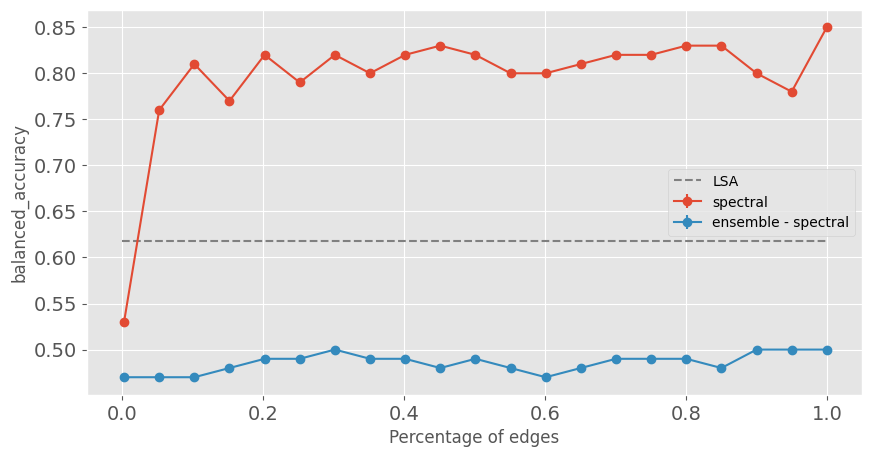

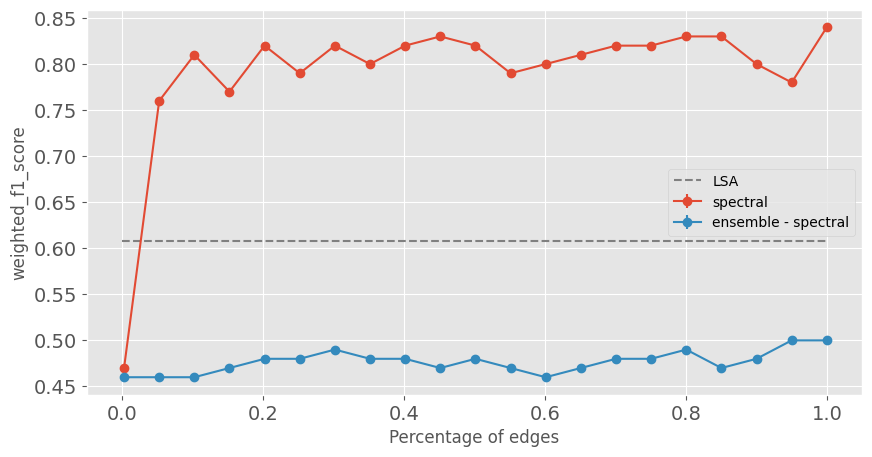

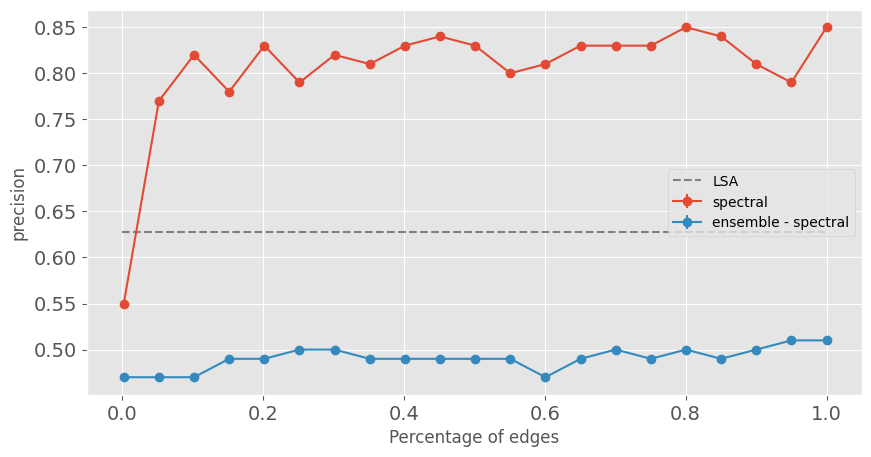

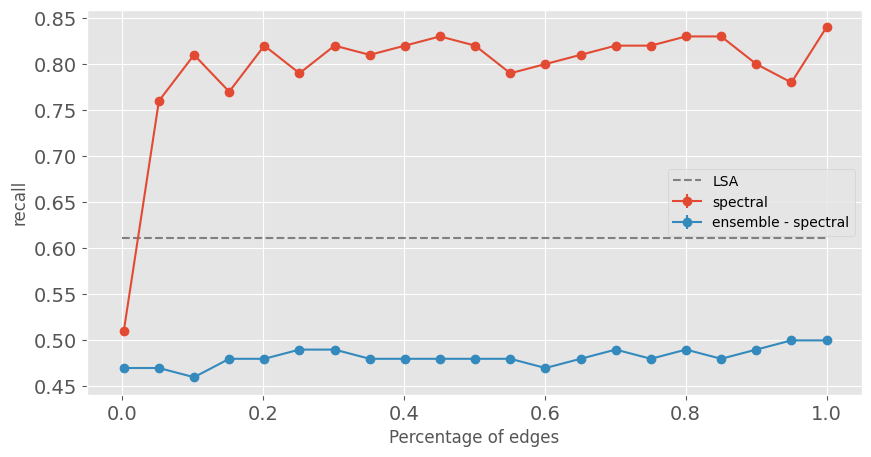

In [55]:
metrics_ = ['balanced_accuracy', 'weighted_f1_score', 'precision', 'recall']
for i, metric_dict in enumerate([global_accs, global_F1s, global_Precs, global_Recs]):
    # Reformat results
    means   = pd.DataFrame.from_dict({feature_mode_: {fraction_: np.mean(accs) for fraction_, accs in metric_dict[feature_mode_].items()} for feature_mode_ in metric_dict.keys()})
    sems    = pd.DataFrame.from_dict({feature_mode_: {fraction_: np.std(accs) / np.sqrt(len(accs)) for fraction_, accs in metric_dict[feature_mode_].items()} for feature_mode_ in metric_dict.keys()})

    # Plot simulation experiment results
    # means.plot(y=['spectral', 'ensemble - spectral'], yerr=sems, fmt='-o', figsize=(10, 5))
    means.plot(y=['node2vec', 'spectral', 'ensemble - node2vec', 'ensemble - spectral'], yerr=sems, fmt='-o', figsize=(10, 5))
    plt.hlines(y=mean.loc[metrics_[i], 'global'], xmin=0, xmax=1, linestyles='dashed', label='LSA', color=['gray'])
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel("Percentage of edges")
    plt.ylabel(metrics_[i])
    plt.legend()
    plt.savefig(f"../reports/figures/{metrics_[i]}_vs_edges.png")
    plt.show()

Is the graph fully connected: True

Graph with 182 nodes and 4772 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:02<00:00, 36.42it/s]


Is the graph fully connected: True

Graph with 182 nodes and 4296 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:02<00:00, 44.41it/s]


Is the graph fully connected: True

Graph with 182 nodes and 3820 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:02<00:00, 49.86it/s]


Is the graph fully connected: True

Graph with 182 nodes and 3344 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 53.56it/s]


Is the graph fully connected: True

Graph with 182 nodes and 2868 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 55.97it/s]


Is the graph fully connected: True

Graph with 182 nodes and 2392 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 60.52it/s]


Is the graph fully connected: True

Graph with 182 nodes and 1916 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:02<00:00, 43.70it/s]


Is the graph fully connected: True

Graph with 182 nodes and 1440 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 54.94it/s]


Is the graph fully connected: True

Graph with 182 nodes and 964 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 77.01it/s]


Is the graph fully connected: False

Graph with 182 nodes and 488 edges


Generating walks (CPU: 1): 100%|██████████| 100/100 [00:01<00:00, 80.83it/s]


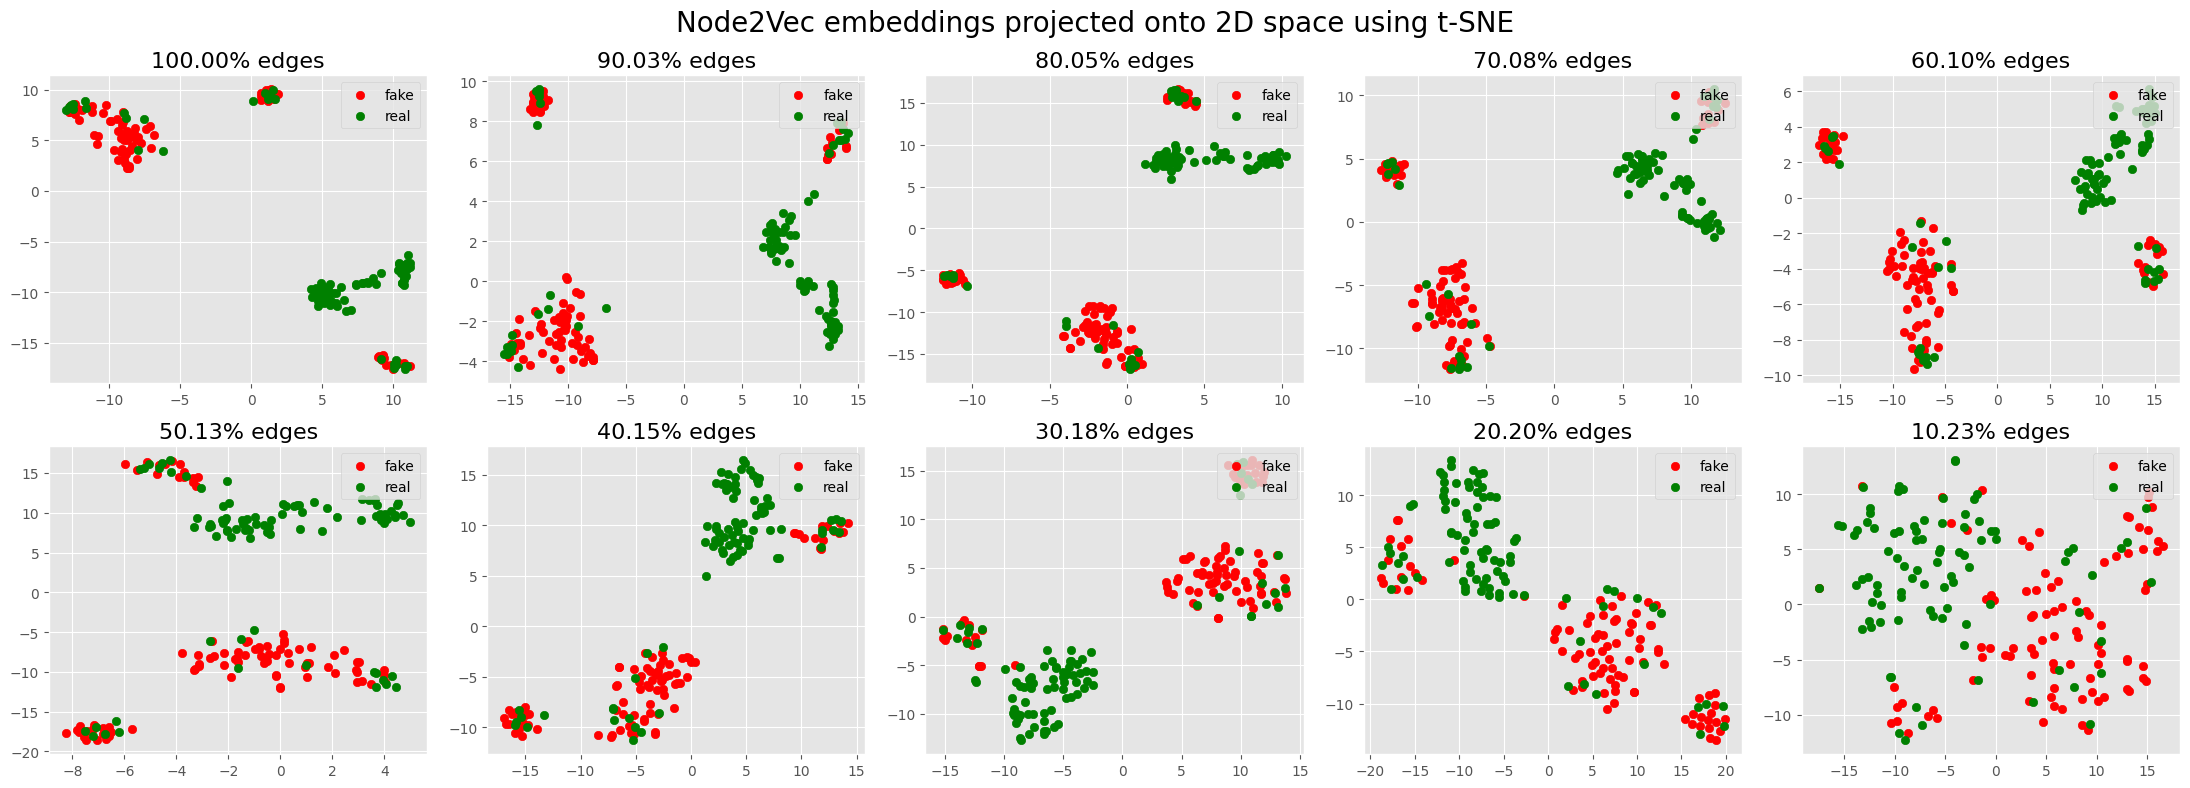

In [62]:
fig, axs = plt.subplots(2, 5, figsize=(22, 8))
for i, g in enumerate(q[:20][::2]):
    # Return graph info
    graph_attributes(g)
    # Plot node2vec embeddings
    plot_node2vec_tsne(g, axs[i // 5, i % 5], total_edges=G.edges.__len__())

fig.suptitle('Node2Vec embeddings projected onto 2D space using t-SNE', fontsize=20)
plt.tight_layout()
plt.show()